In [ ]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import SelectKBest, f_classif
import numpy as np
from sklearn.feature_selection import SelectKBest,chi2, f_regression
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import folium
from folium.plugins import HeatMap
from scipy.stats import chi2_contingency
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import matplotlib.patches as mpatches
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
from scipy.stats import norm
from sklearn.model_selection import cross_val_score
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np
import folium
from folium.plugins import HeatMap

In [2]:
## Join the accident dataframe with the vehicle and casualty to analyse if the trend in the accident data to see the hours and day where most of the accidents occur.

In [3]:
# Connect to sqlite database
conn = sqlite3.connect('accident_data_v1.0.0_2023.db')

# Query for accident table for year 2020
accidents_2020 = pd.read_sql_query("""
  SELECT * FROM accident 
  WHERE accident_year = 2020
""", conn)

# Query for casualty table for matching accident_index
casualties_2020 = pd.read_sql_query("""
  SELECT * FROM casualty
  WHERE accident_index IN (SELECT accident_index FROM accident WHERE accident_year = 2020)
""", conn)

# Query for vehicle table for matching accident_index
vehicles_2020 = pd.read_sql_query("""
  SELECT * FROM vehicle
  WHERE accident_index IN (SELECT accident_index FROM accident WHERE accident_year = 2020)
""", conn)

# Query for lsoa table 
lsoas = pd.read_sql_query("SELECT * FROM lsoa", conn)

# Join accident and casualty based on accident_index
accidents_casualties = accidents_2020.merge(casualties_2020, on='accident_index')

# Join accident and vehicle on accident_index  
accidents_vehicles = accidents_2020.merge(vehicles_2020, on='accident_index')

# Join accident and lsoa on lsoa_of_accident_location
accidents_lsoas = accidents_2020.merge(lsoas, left_on='lsoa_of_accident_location', right_on='lsoa01cd')

# Printing the joined dataframes
print(accidents_casualties.head())
print(accidents_vehicles.head()) 
print(accidents_lsoas.head())

  accident_index  accident_year_x accident_reference_x  location_easting_osgr  \
0  2020010219808             2020            010219808               521389.0   
1  2020010220496             2020            010220496               529337.0   
2  2020010220496             2020            010220496               529337.0   
3  2020010228005             2020            010228005               526432.0   
4  2020010228006             2020            010228006               538676.0   

   location_northing_osgr  longitude   latitude  police_force  \
0                175144.0  -0.254001  51.462262             1   
1                176237.0  -0.139253  51.470327             1   
2                176237.0  -0.139253  51.470327             1   
3                182761.0  -0.178719  51.529614             1   
4                184371.0  -0.001683  51.541210             1   

   accident_severity  number_of_vehicles  ...  age_band_of_casualty  \
0                  3                   1  ...      

In [4]:
## Making the different tables into different dataframe to work easily

In [5]:
# Create new DataFrames 
accidents_2020_df = pd.DataFrame()
casualties_2020_df = pd.DataFrame()
vehicles_2020_df = pd.DataFrame()
lsoa_df = pd.DataFrame()
# Append filtered data into dataframe
accidents_2020_df = accidents_2020_df.append(accidents_2020)
casualties_2020_df = casualties_2020_df.append(casualties_2020)
vehicles_2020_df = vehicles_2020_df.append(vehicles_2020)
lsoa_df = lsoa_df.append(lsoas)

# Save to CSV 
accidents_2020_df.to_csv('accidents_2020.csv', index=False)
casualties_2020_df.to_csv('casualties_2020.csv', index=False)
vehicles_2020_df.to_csv('vehicles_2020.csv', index=False)
lsoa_df.to_csv('lsoa.csv', index= False)

C:\Users\HP\AppData\Local\Temp\ipykernel_30564\3077585326.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accidents_2020_df = accidents_2020_df.append(accidents_2020)
C:\Users\HP\AppData\Local\Temp\ipykernel_30564\3077585326.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  casualties_2020_df = casualties_2020_df.append(casualties_2020)
C:\Users\HP\AppData\Local\Temp\ipykernel_30564\3077585326.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vehicles_2020_df = vehicles_2020_df.append(vehicles_2020)
C:\Users\HP\AppData\Local\Temp\ipykernel_30564\3077585326.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  lsoa_df = lsoa_df.ap

## Data cleaning

In [6]:
# Displaying first few rows of each dataframe
accidents_2020_df.head(), vehicles_2020_df.head(), casualties_2020_df.head()

(  accident_index  accident_year accident_reference  location_easting_osgr  \
 0  2020010219808           2020          010219808               521389.0   
 1  2020010220496           2020          010220496               529337.0   
 2  2020010228005           2020          010228005               526432.0   
 3  2020010228006           2020          010228006               538676.0   
 4  2020010228011           2020          010228011               529324.0   
 
    location_northing_osgr  longitude   latitude  police_force  \
 0                175144.0  -0.254001  51.462262             1   
 1                176237.0  -0.139253  51.470327             1   
 2                182761.0  -0.178719  51.529614             1   
 3                184371.0  -0.001683  51.541210             1   
 4                181286.0  -0.137592  51.515704             1   
 
    accident_severity  number_of_vehicles  ...  \
 0                  3                   1  ...   
 1                  3           

In [7]:
# Displaying basic information of each dataframe
accidents_info = accidents_2020_df.info()
vehicles_info = vehicles_2020_df.info()
casualties_info = casualties_2020_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91199 entries, 0 to 91198
Data columns (total 36 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   accident_index                               91199 non-null  object 
 1   accident_year                                91199 non-null  int64  
 2   accident_reference                           91199 non-null  object 
 3   location_easting_osgr                        91185 non-null  float64
 4   location_northing_osgr                       91185 non-null  float64
 5   longitude                                    91185 non-null  float64
 6   latitude                                     91185 non-null  float64
 7   police_force                                 91199 non-null  int64  
 8   accident_severity                            91199 non-null  int64  
 9   number_of_vehicles                           91199 non-null  int64  
 10

In [8]:
# Checking for missing values in each dataframe
accidents_missing = accidents_2020_df.isnull().sum()
vehicles_missing = vehicles_2020_df.isnull().sum()
casualties_missing = casualties_2020_df.isnull().sum()

accidents_missing[accidents_missing > 0], vehicles_missing[vehicles_missing > 0], casualties_missing[casualties_missing > 0]


(location_easting_osgr     14
 location_northing_osgr    14
 longitude                 14
 latitude                  14
 dtype: int64,
 Series([], dtype: int64),
 Series([], dtype: int64))

In [9]:
## negative values

In [10]:
# Replacing negative values in specified columns
accidents_2020_df.loc[accidents_2020_df['light_conditions'] < 0, 'light_conditions'] = 7
accidents_2020_df.loc[accidents_2020_df['weather_conditions'] < 0, 'weather_conditions'] = 9
accidents_2020_df.loc[accidents_2020_df['road_surface_conditions'] < 0, 'road_surface_conditions'] = np.nan

# Verifying the changes
negative_counts_after_replacement = accidents_2020_df[['light_conditions', 'weather_conditions', 'road_surface_conditions']].lt(0).sum()
negative_counts_after_replacement


light_conditions           0
weather_conditions         0
road_surface_conditions    0
dtype: int64

## impute the missing latiude and longitude based on the mean value of the latitude and longitude in the corresponding lsoa

In [11]:
# # Compute the mean latitude and longitude for each LSOA code
# lsoa_location_mean = accidents_2020_df.groupby('lsoa_of_accident_location')[['latitude', 'longitude']].mean().reset_index()

# # Fill missing values in the accidents dataframe using this mapping
# for index, row in accidents_2020_df[accidents_2020_df['latitude'].isnull() | accidents_2020_df['longitude'].isnull()].iterrows():
#     lsoa_code = row['lsoa_of_accident_location']
#     mean_values = lsoa_location_mean[lsoa_location_mean['lsoa_of_accident_location'] == lsoa_code]
    
#     if not mean_values.empty:
#         accidents_2020_df.at[index, 'latitude'] = mean_values['latitude'].values[0]
#         accidents_2020_df.at[index, 'longitude'] = mean_values['longitude'].values[0]

# # Check if missing values have been addressed for latitude and longitude
# remaining_missing_lat_long = accidents_2020_df[['latitude', 'longitude']].isnull().sum()

# remaining_missing_lat_long


In [12]:
# Checking the first few rows of casualties_2020_df
casualties_2020_df.head()

,casualty_index,accident_index,accident_year,accident_reference,vehicle_reference,casualty_reference,casualty_class,sex_of_casualty,age_of_casualty,age_band_of_casualty,casualty_severity,pedestrian_location,pedestrian_movement,car_passenger,bus_or_coach_passenger,pedestrian_road_maintenance_worker,casualty_type,casualty_home_area_type,casualty_imd_decile
0,484748,2020010219808,2020,010219808,1,1,3,1,31,6,3,9,5,0,0,0,0,1,4
1,484749,2020010220496,2020,010220496,1,1,3,2,2,1,3,1,1,0,0,0,0,1,2
2,484750,2020010220496,2020,010220496,1,2,3,2,4,1,3,1,1,0,0,0,0,1,2
3,484751,2020010228005,2020,010228005,1,1,3,1,23,5,3,5,9,0,0,0,0,1,3
4,484752,2020010228006,2020,010228006,1,1,3,1,47,8,2,4,1,0,0,0,0,1,3


In [13]:
# Checking for missing values in casualties_2020_df
missing_values_casualties = casualties_2020_df.isnull().sum()

# Checking for blanks in casualties_2020_df
blank_values_casualties = (casualties_2020_df == ' ').sum()

missing_values_casualties, blank_values_casualties


(casualty_index                        0
 accident_index                        0
 accident_year                         0
 accident_reference                    0
 vehicle_reference                     0
 casualty_reference                    0
 casualty_class                        0
 sex_of_casualty                       0
 age_of_casualty                       0
 age_band_of_casualty                  0
 casualty_severity                     0
 pedestrian_location                   0
 pedestrian_movement                   0
 car_passenger                         0
 bus_or_coach_passenger                0
 pedestrian_road_maintenance_worker    0
 casualty_type                         0
 casualty_home_area_type               0
 casualty_imd_decile                   0
 dtype: int64,
 casualty_index                        0
 accident_index                        0
 accident_year                         0
 accident_reference                    0
 vehicle_reference                     0
 

In [14]:
# Checking for negative values in numerical columns of casualties_2020_df
negative_values_casualties = casualties_2020_df[casualties_2020_df.select_dtypes(include=[np.number]).columns].lt(0).sum()

negative_values_casualties = negative_values_casualties[negative_values_casualties > 0]
negative_values_casualties


sex_of_casualty                         756
age_of_casualty                        2481
age_band_of_casualty                   2481
pedestrian_location                       2
pedestrian_movement                       2
car_passenger                           311
bus_or_coach_passenger                   22
pedestrian_road_maintenance_worker       94
casualty_home_area_type               10762
casualty_imd_decile                   10910
dtype: int64

In [15]:
# Imputing age_of_casualty and age_band_of_casualty with their respective medians
median_age = casualties_2020_df['age_of_casualty'].median()
median_age_band = casualties_2020_df['age_band_of_casualty'].median()

casualties_2020_df.loc[casualties_2020_df['age_of_casualty'] < 0, 'age_of_casualty'] = median_age
casualties_2020_df.loc[casualties_2020_df['age_band_of_casualty'] < 0, 'age_band_of_casualty'] = median_age_band

# Imputing sex_of_casualty
# Where it's -1, replace with 1
casualties_2020_df.loc[casualties_2020_df['sex_of_casualty'] == -1, 'sex_of_casualty'] = 1

# For other negative values, split them half to 1 and half to 2
negative_sex_indices = casualties_2020_df[casualties_2020_df['sex_of_casualty'] < 0].index
half_length = len(negative_sex_indices) // 2
casualties_2020_df.loc[negative_sex_indices[:half_length], 'sex_of_casualty'] = 1
casualties_2020_df.loc[negative_sex_indices[half_length:], 'sex_of_casualty'] = 2

# Verify the changes
negative_values_after_replacement = casualties_2020_df[['age_of_casualty', 'age_band_of_casualty', 'sex_of_casualty']].lt(0).sum()
negative_values_after_replacement


age_of_casualty         0
age_band_of_casualty    0
sex_of_casualty         0
dtype: int64

In [16]:
#vehicle
# Display the first few rows
vehicles_2020_df.head()


,vehicle_index,accident_index,accident_year,accident_reference,vehicle_reference,vehicle_type,towing_and_articulation,vehicle_manoeuvre,vehicle_direction_from,vehicle_direction_to,...,journey_purpose_of_driver,sex_of_driver,age_of_driver,age_band_of_driver,engine_capacity_cc,propulsion_code,age_of_vehicle,generic_make_model,driver_imd_decile,driver_home_area_type
0,681716,2020010219808,2020,010219808,1,9,9,5,1,5,...,6,2,32,6,1968,2,6,AUDI Q5,4,1
1,681717,2020010220496,2020,010220496,1,9,0,4,2,6,...,2,1,45,7,1395,1,2,AUDI A1,7,1
2,681718,2020010228005,2020,010228005,1,9,0,18,-1,-1,...,6,3,-1,-1,-1,-1,-1,-1,-1,-1
3,681719,2020010228006,2020,010228006,1,8,0,18,1,5,...,1,1,44,7,1798,8,8,TOYOTA PRIUS,2,1
4,681720,2020010228011,2020,010228011,1,9,0,18,3,7,...,6,1,20,4,2993,2,4,BMW 4 SERIES,-1,-1


In [17]:
# Checking for missing values and blanks in vehicles_2020_df
missing_values_vehicles = vehicles_2020_df.isnull().sum()
blank_spaces_vehicles = (vehicles_2020_df == ' ').sum()

missing_and_blank_vehicles = missing_values_vehicles + blank_spaces_vehicles
missing_and_blank_vehicles[missing_and_blank_vehicles > 0]


Series([], dtype: int64)

## Outlier analysis

In [18]:
# Loading the data
accident_data = accidents_2020_df

# Define a function to perform Grubbs test and identify outliers
def find_outliers(column):
    z_scores = np.abs(zscore(column))
    z_mean = np.mean(z_scores)
    z_std = np.std(z_scores)
    
    alpha = 0.05
    critical_value = norm.ppf(1 - alpha / (2 * len(column)))
    
    outliers = []
    for i, z in enumerate(z_scores):
        if z > critical_value:
            outliers.append((i, column[i]))
    return outliers

# Iterate through numerical columns and find outliers
numerical_columns = accident_data.select_dtypes(include=[np.number]).columns
columns_with_outliers = []
for column in numerical_columns:
    outliers = find_outliers(accident_data[column])
    if len(outliers) > 0:
        columns_with_outliers.append(column)

print("Columns with outliers detected:")
for column in columns_with_outliers:
    print(f"  {column}")


Columns with outliers detected:
  number_of_vehicles
  number_of_casualties
  first_road_number
  junction_detail
  second_road_number
  pedestrian_crossing_human_control
  special_conditions_at_site
  carriageway_hazards


In [19]:
# Load the dataframe
data = accidents_2020_df

# Define a function to perform Grubbs test and identify outliers
def find_outliers(column):
    z_scores = np.abs(zscore(column))
    z_mean = np.mean(z_scores)
    z_std = np.std(z_scores)
    
    alpha = 0.05
    critical_value = norm.ppf(1 - alpha / (2 * len(column)))
    
    outliers = []
    for i, z in enumerate(z_scores):
        if z > critical_value:
            outliers.append((i, column[i]))
    return outliers, z_mean

# Iterate through numerical columns and find outliers
numerical_columns = data.select_dtypes(include=[np.number]).columns
for column in numerical_columns:
    outliers, mean_z_score = find_outliers(data[column])
    if len(outliers) > 0:
        print(f"Outliers in column '{column}':")
        print(f"Mean Z-Score for '{column}': {mean_z_score:.4f}")
        for idx, value in outliers:
            print(f"  Outlier detected at index {idx}, value: {value}")


Outliers in column 'number_of_vehicles':
Mean Z-Score for 'number_of_vehicles': 0.6959
  Outlier detected at index 97, value: 8
  Outlier detected at index 126, value: 6
  Outlier detected at index 223, value: 7
  Outlier detected at index 386, value: 8
  Outlier detected at index 1842, value: 6
  Outlier detected at index 2215, value: 7
  Outlier detected at index 2520, value: 6
  Outlier detected at index 3102, value: 8
  Outlier detected at index 3780, value: 7
  Outlier detected at index 4308, value: 7
  Outlier detected at index 4440, value: 6
  Outlier detected at index 5309, value: 6
  Outlier detected at index 7159, value: 6
  Outlier detected at index 7302, value: 6
  Outlier detected at index 7305, value: 7
  Outlier detected at index 9685, value: 6
  Outlier detected at index 9812, value: 9
  Outlier detected at index 11654, value: 6
  Outlier detected at index 11780, value: 6
  Outlier detected at index 11875, value: 6
  Outlier detected at index 12533, value: 6
  Outlier d

In [20]:
import numpy as np
from scipy.stats import zscore
from scipy.stats import norm
import pandas as pd

# Load the data in the dataframe
data = vehicles_2020_df

# Define a function to perform Grubbs test and identify outliers
def find_outliers(column):
    z_scores = np.abs(zscore(column))
    z_mean = np.mean(z_scores)
    z_std = np.std(z_scores)
    
    alpha = 0.05
    critical_value = norm.ppf(1 - alpha / (2 * len(column)))
    
    outliers = []
    for i, z in enumerate(z_scores):
        if z > critical_value:
            outliers.append((i, column[i]))
    return outliers

# Iterate through numerical columns and find outliers
numerical_columns = data.select_dtypes(include=[np.number]).columns
columns_with_outliers = []
for column in numerical_columns:
    outliers = find_outliers(data[column])
    if len(outliers) > 0:
        columns_with_outliers.append(column)

print("Columns with outliers are:")
for column in columns_with_outliers:
    print(f"  {column}")


Columns with outliers are:
  vehicle_reference
  vehicle_type
  towing_and_articulation
  engine_capacity_cc
  propulsion_code
  age_of_vehicle


In [21]:
# Load the vehicle data
data = vehicles_2020_df

# Defining a function to perform Grubbs test and identify outliers
def find_outliers(column):
    z_scores = np.abs(zscore(column))
    z_mean = np.mean(z_scores)
    z_std = np.std(z_scores)
    
    alpha = 0.05
    critical_value = norm.ppf(1 - alpha / (2 * len(column)))
    
    outliers = []
    for i, z in enumerate(z_scores):
        if z > critical_value:
            outliers.append((i, column[i]))
    return outliers, z_mean

# Iterate through numerical columns and find outliers
numerical_columns = data.select_dtypes(include=[np.number]).columns
for column in numerical_columns:
    outliers, mean_z_score = find_outliers(data[column])
    if len(outliers) > 0:
        print(f"Outliers in column '{column}':")
        print(f"Mean Z-Score for '{column}': {mean_z_score:.4f}")
        for idx, value in outliers:
            print(f"  Outlier detected at index {idx}, value: {value}")


Outliers in column 'vehicle_reference':
Mean Z-Score for 'vehicle_reference': 0.2357
  Outlier detected at index 55185, value: 999
Outliers in column 'vehicle_type':
Mean Z-Score for 'vehicle_type': 0.3767
  Outlier detected at index 47, value: 90
  Outlier detected at index 62, value: 90
  Outlier detected at index 204, value: 97
  Outlier detected at index 249, value: 90
  Outlier detected at index 612, value: 98
  Outlier detected at index 646, value: 90
  Outlier detected at index 681, value: 90
  Outlier detected at index 759, value: 90
  Outlier detected at index 867, value: 97
  Outlier detected at index 880, value: 98
  Outlier detected at index 1264, value: 98
  Outlier detected at index 1331, value: 97
  Outlier detected at index 1368, value: 90
  Outlier detected at index 1666, value: 90
  Outlier detected at index 1667, value: 90
  Outlier detected at index 1736, value: 97
  Outlier detected at index 1767, value: 98
  Outlier detected at index 1822, value: 90
  Outlier dete

In [22]:
import numpy as np
from scipy.stats import zscore
from scipy.stats import norm
import pandas as pd

# Load tha casualty dataframe
data = casualties_2020_df

# Define a function to perform Grubbs test and identify outliers
def find_outliers(column):
    z_scores = np.abs(zscore(column))
    z_mean = np.mean(z_scores)
    z_std = np.std(z_scores)
    
    alpha = 0.05
    critical_value = norm.ppf(1 - alpha / (2 * len(column)))
    
    outliers = []
    for i, z in enumerate(z_scores):
        if z > critical_value:
            outliers.append((i, column[i]))
    return outliers

# Iterate through numerical columns and find outliers
numerical_columns = data.select_dtypes(include=[np.number]).columns
columns_with_outliers = []
for column in numerical_columns:
    outliers = find_outliers(data[column])
    if len(outliers) > 0:
        columns_with_outliers.append(column)

print("Columns with outliers detected:")
for column in columns_with_outliers:
    print(f"  {column}")


Columns with outliers detected:
  vehicle_reference
  casualty_reference
  sex_of_casualty
  car_passenger
  bus_or_coach_passenger
  pedestrian_road_maintenance_worker
  casualty_type


In [23]:
# Load the data 
data = casualties_2020_df

# Define a function to perform Grubbs' test and identify outliers
def find_outliers(column):
    z_scores = np.abs(zscore(column))
    z_mean = np.mean(z_scores)
    z_std = np.std(z_scores)
    
    alpha = 0.05
    critical_value = norm.ppf(1 - alpha / (2 * len(column)))
    
    outliers = []
    for i, z in enumerate(z_scores):
        if z > critical_value:
            outliers.append((i, column[i]))
    return outliers

# Iterate through numerical columns and find outliers
numerical_columns = data.select_dtypes(include=[np.number])
for column in numerical_columns:
    outliers = find_outliers(data[column])
    if len(outliers) > 0:
        print(f"Outliers in column '{column}':")
        for idx, value in outliers:
            print(f"  Outlier detected at index {idx}, value: {value}")


Outliers in column 'vehicle_reference':
  Outlier detected at index 36090, value: 999
Outliers in column 'casualty_reference':
  Outlier detected at index 28912, value: 40
  Outlier detected at index 74142, value: 33
  Outlier detected at index 84398, value: 22
  Outlier detected at index 84399, value: 23
  Outlier detected at index 84400, value: 24
  Outlier detected at index 84401, value: 25
  Outlier detected at index 84402, value: 26
  Outlier detected at index 84403, value: 27
  Outlier detected at index 84404, value: 28
  Outlier detected at index 84405, value: 29
  Outlier detected at index 84406, value: 30
  Outlier detected at index 84407, value: 31
  Outlier detected at index 84408, value: 32
  Outlier detected at index 84409, value: 33
  Outlier detected at index 84410, value: 34
  Outlier detected at index 84411, value: 35
  Outlier detected at index 84412, value: 36
  Outlier detected at index 84413, value: 37
  Outlier detected at index 84414, value: 38
  Outlier detected

In [24]:
## Outliers in the accident table using the gribbs test

In [25]:
accidents_2020_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91199 entries, 0 to 91198
Data columns (total 36 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   accident_index                               91199 non-null  object 
 1   accident_year                                91199 non-null  int64  
 2   accident_reference                           91199 non-null  object 
 3   location_easting_osgr                        91185 non-null  float64
 4   location_northing_osgr                       91185 non-null  float64
 5   longitude                                    91185 non-null  float64
 6   latitude                                     91185 non-null  float64
 7   police_force                                 91199 non-null  int64  
 8   accident_severity                            91199 non-null  int64  
 9   number_of_vehicles                           91199 non-null  int64  
 10

In [26]:
import numpy as np
from scipy.stats import zscore
from scipy.stats import norm
import pandas as pd

# Load the data in the dataframe
data = accidents_2020_df

# List of selected numerical variables
selected_columns = ['accident_severity', 'number_of_vehicles']  

# Define a function to perform Grubbs' test and identify outliers
def find_outliers(column):
    z_scores = np.abs(zscore(column))
    z_mean = np.mean(z_scores)
    z_std = np.std(z_scores)
    
    alpha = 0.05
    critical_value = norm.ppf(1 - alpha / (2 * len(column)))
    
    outliers = []
    for i, z in enumerate(z_scores):
        if z > critical_value:
            outliers.append((i, column[i]))
    return outliers, z_mean

# Iterate through selected numerical columns and find outliers
for column in selected_columns:
    outliers, mean_z_score = find_outliers(data[column])
    if len(outliers) > 0:
        print(f"Outliers in column '{column}':")
        for idx, value in outliers:
            print(f"  Outlier detected at index {idx}, value: {value}")
        print(f"Mean Z-Score for '{column}': {mean_z_score:.4f}")


Outliers in column 'number_of_vehicles':
  Outlier detected at index 97, value: 8
  Outlier detected at index 126, value: 6
  Outlier detected at index 223, value: 7
  Outlier detected at index 386, value: 8
  Outlier detected at index 1842, value: 6
  Outlier detected at index 2215, value: 7
  Outlier detected at index 2520, value: 6
  Outlier detected at index 3102, value: 8
  Outlier detected at index 3780, value: 7
  Outlier detected at index 4308, value: 7
  Outlier detected at index 4440, value: 6
  Outlier detected at index 5309, value: 6
  Outlier detected at index 7159, value: 6
  Outlier detected at index 7302, value: 6
  Outlier detected at index 7305, value: 7
  Outlier detected at index 9685, value: 6
  Outlier detected at index 9812, value: 9
  Outlier detected at index 11654, value: 6
  Outlier detected at index 11780, value: 6
  Outlier detected at index 11875, value: 6
  Outlier detected at index 12533, value: 6
  Outlier detected at index 12967, value: 7
  Outlier det

## Aggregating the accident data based on the hour and day the accident occured

In [27]:
# Load filtered accident data
accidents = accidents_2020_df 

# Convert time and date columns to datetime
accidents['time'] = pd.to_datetime(accidents['time'])
accidents['date'] = pd.to_datetime(accidents['date'])

# Add columns for hour of day and day of week
accidents['hour'] = accidents['time'].dt.hour

# Aggregate by hour and day of week, count accidents 
accidents_by_time = accidents.groupby(['hour', 'day_of_week'])['accident_index'].count().reset_index(name='count')

# Print aggregated data
print(accidents_by_time.head())



   hour  day_of_week  count
0     0            1    306
1     0            2    125
2     0            3    109
3     0            4    133
4     0            5    129


C:\Users\HP\anaconda3\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '27/04/2020' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
C:\Users\HP\anaconda3\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '13/01/2020' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
C:\Users\HP\anaconda3\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '14/01/2020' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
C:\Users\HP\anaconda3\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '15/01/2020' in DD/MM/YYYY format. Provide format or specify infer_date

In [28]:
accidents_by_time

,hour,day_of_week,count
0,0,1,306
1,0,2,125
2,0,3,109
3,0,4,133
4,0,5,129
...,...,...,...
163,23,3,192
164,23,4,228
165,23,5,226
166,23,6,363


## Calculating the accident rate for each hour of the day and the day of the week

In [29]:
# Calculate the total number of days in the dataset
total_days = accidents['date'].nunique()

# Calculate the total number of occurrences for each hour of the day and each day of the week
accidents_by_hour = accidents.groupby('hour')['accident_index'].count().reset_index(name='total_occurrences_by_hour')
accidents_by_weekday = accidents.groupby('day_of_week')['accident_index'].count().reset_index(name='total_occurrences_by_weekday')

# Merge the dataframes to calculate the accident rate
accidents_rate_by_hour = pd.merge(accidents_by_time, accidents_by_hour, on='hour')
accidents_rate_by_weekday = pd.merge(accidents_by_time, accidents_by_weekday, on='day_of_week')

# Calculate the accident rate for each hour of the day and each day of the week
accidents_rate_by_hour['accident_rate'] = accidents_rate_by_hour['count'] / accidents_rate_by_hour['total_occurrences_by_hour']
accidents_rate_by_weekday['accident_rate'] = accidents_rate_by_weekday['count'] / accidents_rate_by_weekday['total_occurrences_by_weekday']

# Print the calculated accident rates
print("Accident Rate by Hour of the Day:")
print(accidents_rate_by_hour)

print("\nAccident Rate by Day of the Week:")
print(accidents_rate_by_weekday)


Accident Rate by Hour of the Day:
     hour  day_of_week  count  total_occurrences_by_hour  accident_rate
0       0            1    306                       1188       0.257576
1       0            2    125                       1188       0.105219
2       0            3    109                       1188       0.091751
3       0            4    133                       1188       0.111953
4       0            5    129                       1188       0.108586
..    ...          ...    ...                        ...            ...
163    23            3    192                       1796       0.106904
164    23            4    228                       1796       0.126949
165    23            5    226                       1796       0.125835
166    23            6    363                       1796       0.202116
167    23            7    387                       1796       0.215479

[168 rows x 5 columns]

Accident Rate by Day of the Week:
     hour  day_of_week  count  total_occurr

## Visualising the accident count and accident rate for each of the hour and day.

## Bar plot

##  accident count per hour using a bar plot

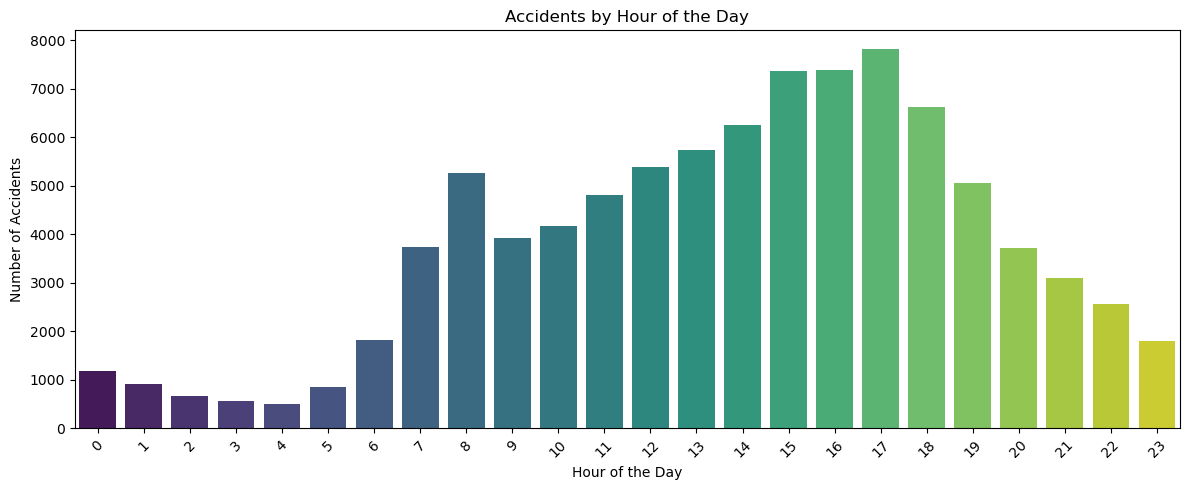

In [40]:
# Convert 'time' column to datetime type
accidents_2020_df['time'] = pd.to_datetime(accidents_2020_df['time'])

# Extract hour information
accidents_2020_df['hour'] = accidents_2020_df['time'].dt.hour

# Plot accidents by hour of the day
plt.figure(figsize=(12, 5))
sns.countplot(data=accidents_2020_df, x='hour', palette="viridis")
plt.title('Accidents by Hour of the Day')
plt.ylabel('Number of Accidents')
plt.xlabel('Hour of the Day')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## accident rate per hour using a bar plot

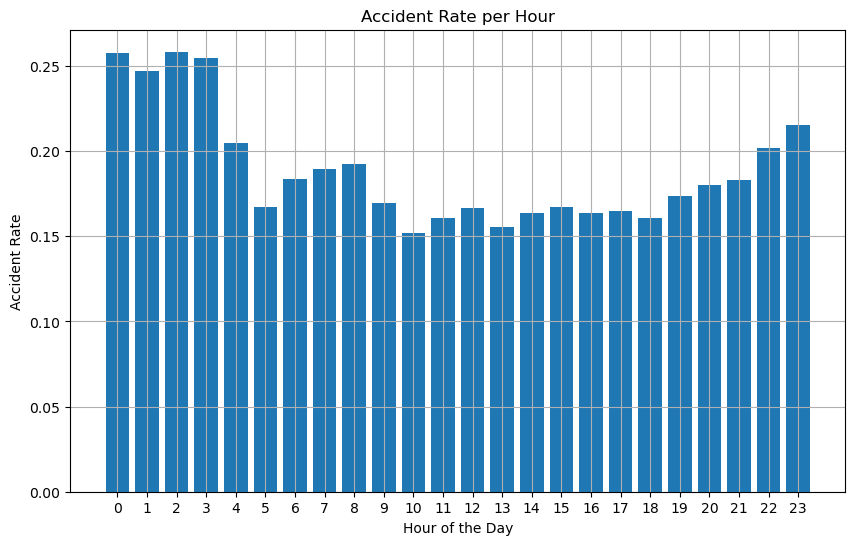

In [31]:
# Create a bar plot for accident rate per hour
plt.figure(figsize=(10, 6))
plt.bar(accidents_rate_by_hour['hour'], accidents_rate_by_hour['accident_rate'])
plt.xlabel('Hour of the Day')
plt.ylabel('Accident Rate')
plt.title('Accident Rate per Hour')
plt.xticks(range(24))
plt.grid(True)
plt.show()


In [32]:
## accident count per day using a bar plot

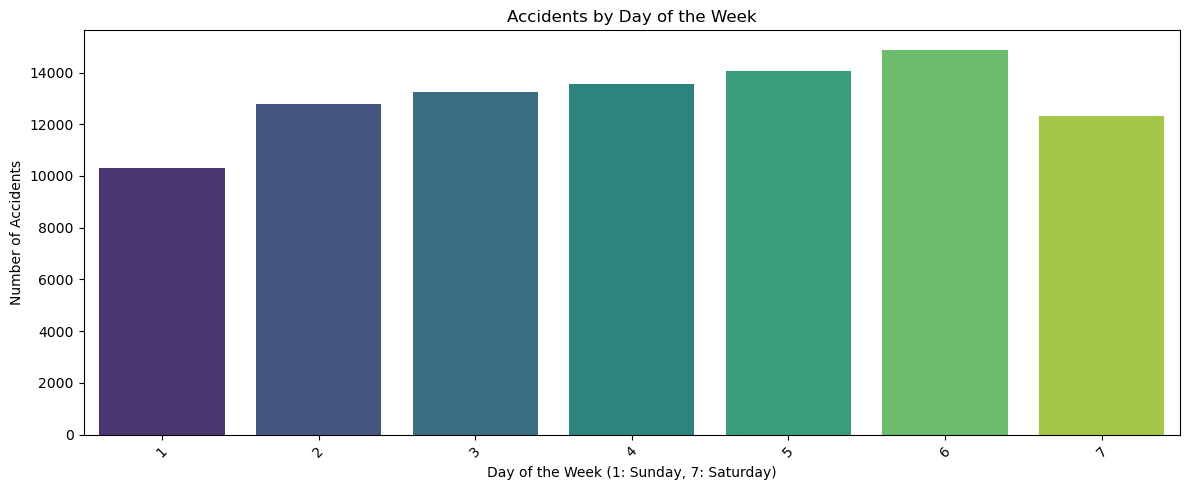

In [33]:
# Plot accidents by day of the week
plt.figure(figsize=(12, 5))
sns.countplot(data=accidents_2020_df, x='day_of_week', palette="viridis", order=range(1, 8))
plt.title('Accidents by Day of the Week')
plt.ylabel('Number of Accidents')
plt.xlabel('Day of the Week (1: Sunday, 7: Saturday)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [34]:
## accident rate per day using a bar plot

# Heat map

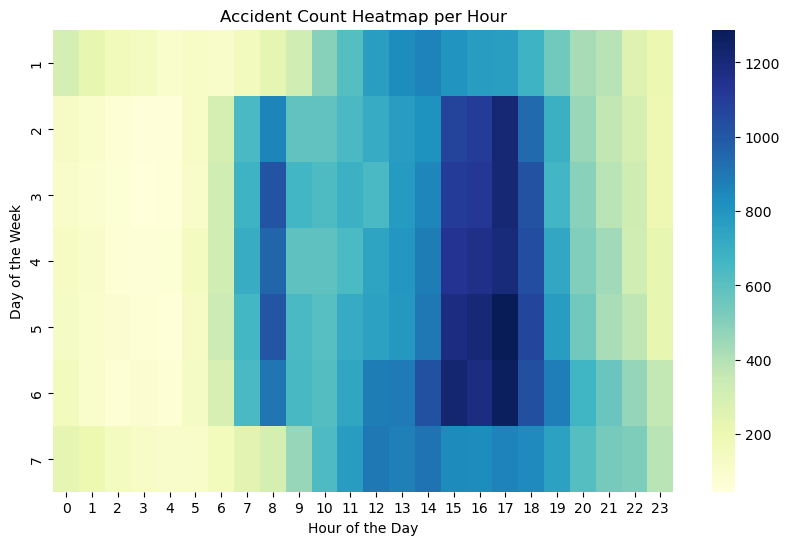

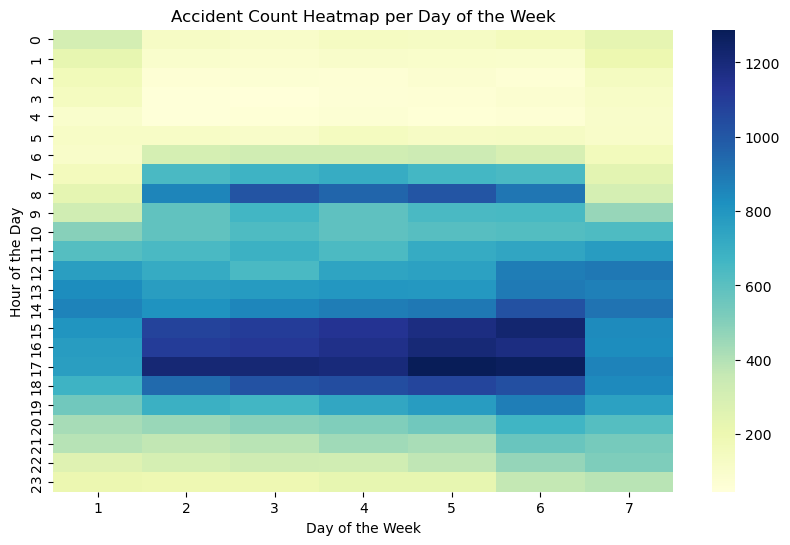

In [47]:
# Create a heatmap for accident count per hour
hourly_heatmap_data = accidents_rate_by_hour.pivot('day_of_week', 'hour', 'count')
plt.figure(figsize=(10, 6))
sns.heatmap(hourly_heatmap_data, cmap='YlGnBu')
plt.xlabel('Hour of the Day')
plt.ylabel('Day of the Week')
plt.title('Accident Count Heatmap per Hour')
plt.show()


# Create a heatmap for accident count per day of the week
weekday_heatmap_data = accidents_rate_by_weekday.pivot('hour', 'day_of_week', 'count')
plt.figure(figsize=(10, 6))
sns.heatmap(weekday_heatmap_data, cmap='YlGnBu', yticklabels=range(24), xticklabels= range(1,8))
plt.xlabel('Day of the Week')
plt.ylabel('Hour of the Day')
plt.title('Accident Count Heatmap per Day of the Week')
plt.show()




## Answer to question number 2

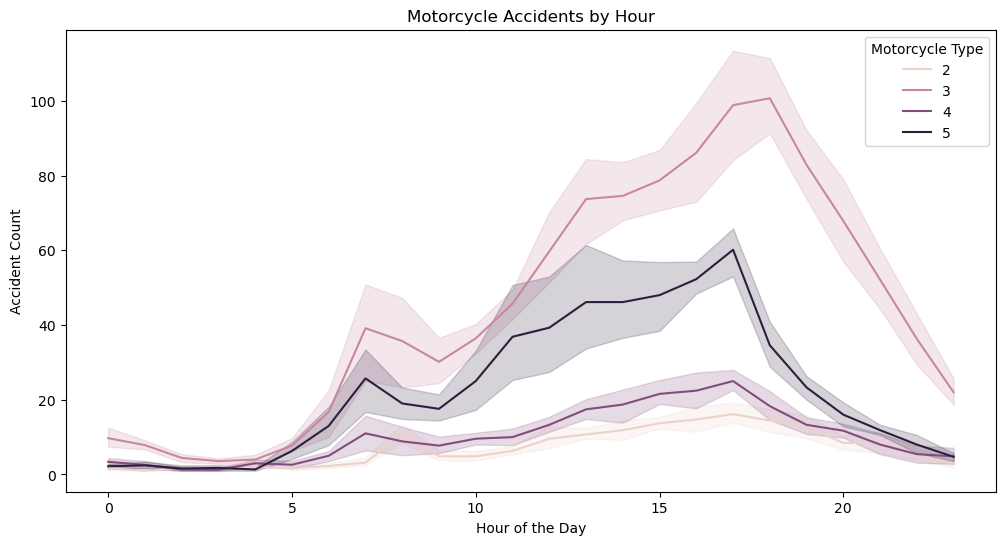

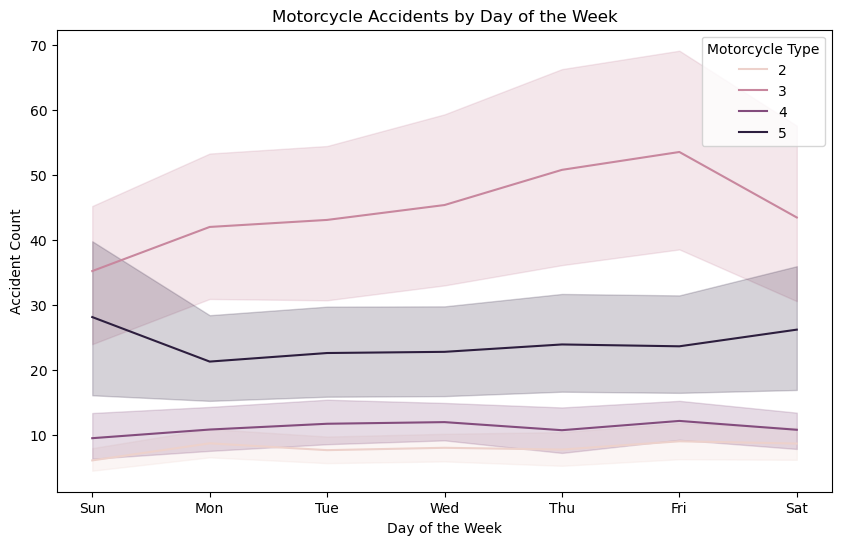

In [41]:
# Merge vehicle data to get vehicle_type information
motorcycle_accidents = accidents_2020.merge(vehicles_2020[['accident_index', 'vehicle_type']], on='accident_index', how='inner')

# Define motorcycle types of interest
motorcycle_types = [2, 3, 4, 5]

# Filter vehicle data for motorcycle types
motorcycles = vehicles_2020[vehicles_2020['vehicle_type'].isin(motorcycle_types)]

# Merge motorcycle vehicle data with accident data using accident_index
motorcycle_accidents = motorcycles.merge(accidents_2020, on='accident_index', how='inner')

# Convert 'time' column to datetime type
motorcycle_accidents['time'] = pd.to_datetime(motorcycle_accidents['time'])

# Extract hour information
motorcycle_accidents['hour'] = motorcycle_accidents['time'].dt.hour

# Filter by motorcycle types of interest
motorcycle_accidents_filtered = motorcycle_accidents[motorcycle_accidents['vehicle_type'].isin(motorcycle_types)]

# Group by day_of_week and hour, count motorcycle accidents
mc_by_time = motorcycle_accidents_filtered.groupby(['vehicle_type', 'day_of_week', 'hour'])['accident_index'].count().reset_index(name='count')

# Create a line chart for accident counts by hour
plt.figure(figsize=(12, 6))
sns.lineplot(data=mc_by_time, x='hour', y='count', hue='vehicle_type')
plt.title("Motorcycle Accidents by Hour")
plt.xlabel("Hour of the Day")
plt.ylabel("Accident Count")
plt.legend(title='Motorcycle Type')
plt.show()

# Create a line chart for accident counts by day of the week
plt.figure(figsize=(10, 6))
sns.lineplot(data=mc_by_time, x='day_of_week', y='count', hue='vehicle_type')
plt.title("Motorcycle Accidents by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Accident Count")
plt.legend(title='Motorcycle Type', loc='upper right')
plt.xticks(range(1, 8), ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])
plt.show()



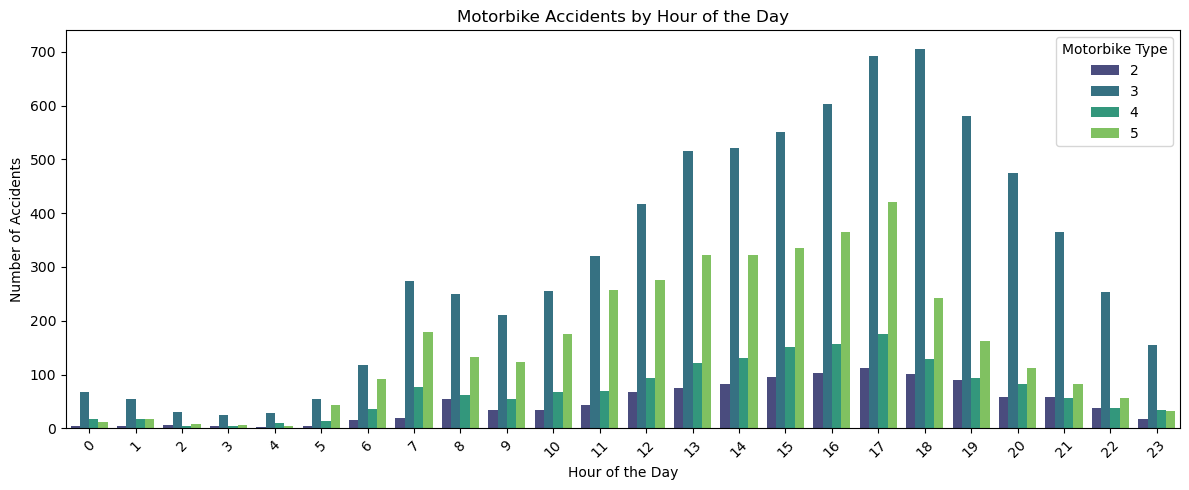

In [50]:
# Plot motorbike accidents by hour of the day
plt.figure(figsize=(12, 5))
sns.countplot(data=motorcycle_accidents, x='hour', hue='vehicle_type', palette="viridis")
plt.title('Motorbike Accidents by Hour of the Day')
plt.ylabel('Number of Accidents')
plt.xlabel('Hour of the Day')
plt.legend(title="Motorbike Type")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

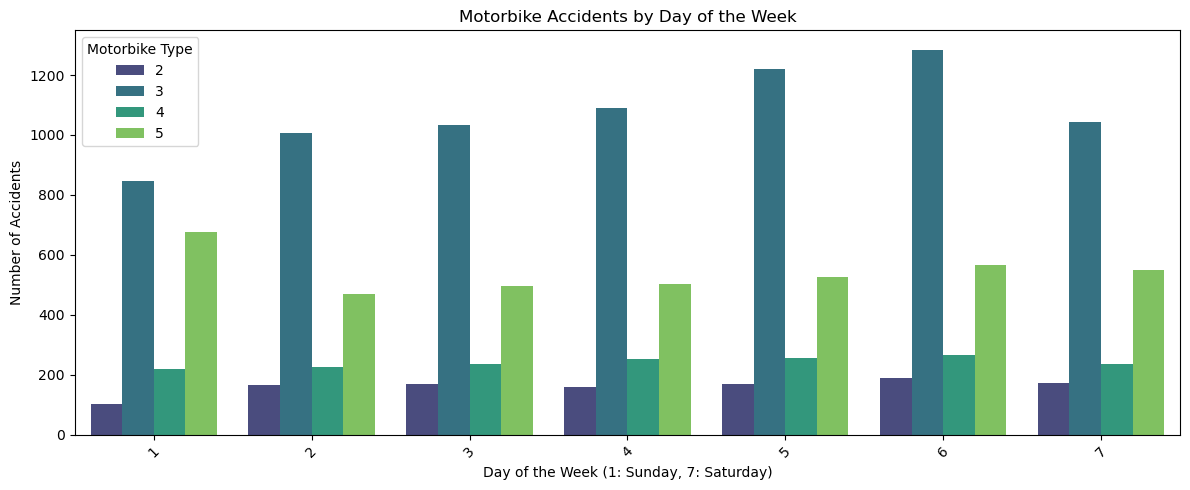

In [51]:
# Plot motorbike accidents by day of the week
plt.figure(figsize=(12, 5))
sns.countplot(data=motorcycle_accidents, x='day_of_week', hue='vehicle_type', palette="viridis", order=range(1, 8))
plt.title('Motorbike Accidents by Day of the Week')
plt.ylabel('Number of Accidents')
plt.xlabel('Day of the Week (1: Sunday, 7: Saturday)')
plt.legend(title="Motorbike Type")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

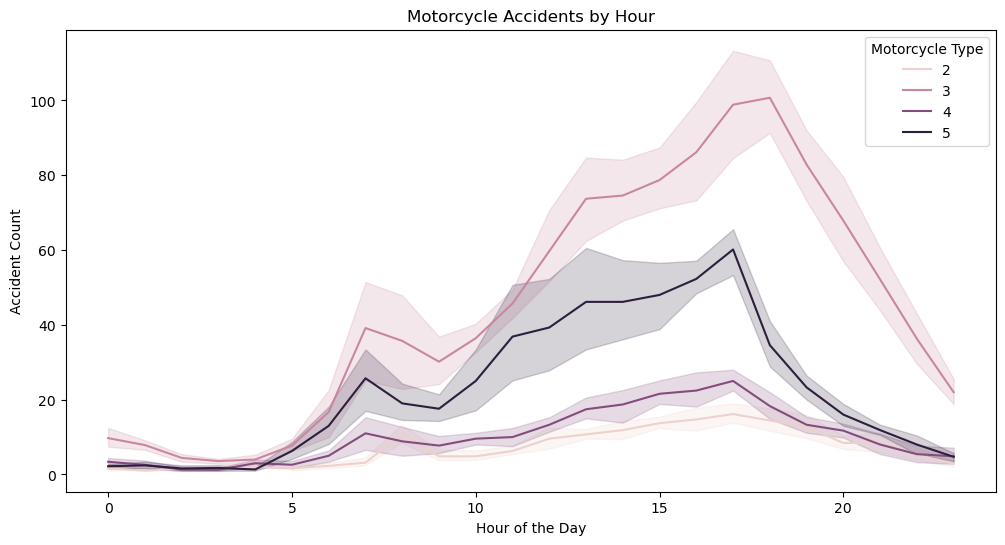

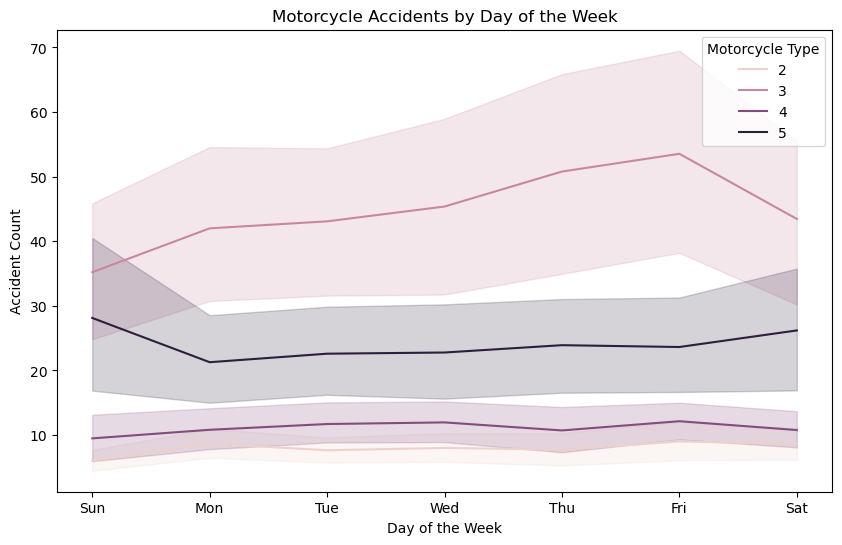

In [48]:
# Merge vehicle data to get 'vehicle_type' information
motorcycle_accidents = accidents_2020.merge(vehicles_2020[['accident_index', 'vehicle_type']], on='accident_index', how='inner')
# Define motorcycle types of interest (based on numerical values)
motorcycle_types = [2, 3, 4, 5]


# Filter vehicle data for motorcycle types
motorcycles = vehicles_2020[vehicles_2020['vehicle_type'].isin(motorcycle_types)]

# Merge motorcycle vehicle data with accident data using accident_index
motorcycle_accidents = motorcycles.merge(accidents_2020, on='accident_index', how='inner')

# Now you have a DataFrame 'motorcycle_accidents' that contains merged data


# # Merge the accidents data to get information about day_of_week and time
# motorcycle_accidents = accidents_2020[accidents_2020['accident_index'].isin(motorcycles['accident_index'])]
# Convert time column to datetime type
motorcycle_accidents['time'] = pd.to_datetime(motorcycle_accidents['time'])


# Extract hour information
motorcycle_accidents['hour'] = motorcycle_accidents['time'].dt.hour

# Filter by motorcycle types of interest
motorcycle_accidents_filtered = motorcycle_accidents[motorcycle_accidents['vehicle_type'].isin(motorcycle_types)]

# Group by day_of_week and hour, count motorcycle accidents
mc_by_time = motorcycle_accidents_filtered.groupby(['vehicle_type', 'day_of_week', 'hour'])['accident_index'].count().reset_index(name='count')

# Create a line chart for accident counts by hour
plt.figure(figsize=(12, 6))
sns.lineplot(data=mc_by_time, x='hour', y='count', hue='vehicle_type')
plt.title("Motorcycle Accidents by Hour")
plt.xlabel("Hour of the Day")
plt.ylabel("Accident Count")
plt.legend(title='Motorcycle Type')
plt.show()

# Create a line chart for accident counts by day of the week
plt.figure(figsize=(10, 6))
sns.lineplot(data=mc_by_time, x='day_of_week', y='count', hue='vehicle_type')
plt.title("Motorcycle Accidents by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Accident Count")
plt.legend(title='Motorcycle Type', loc='upper right')
plt.xticks(range(1, 8), ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])
plt.show()


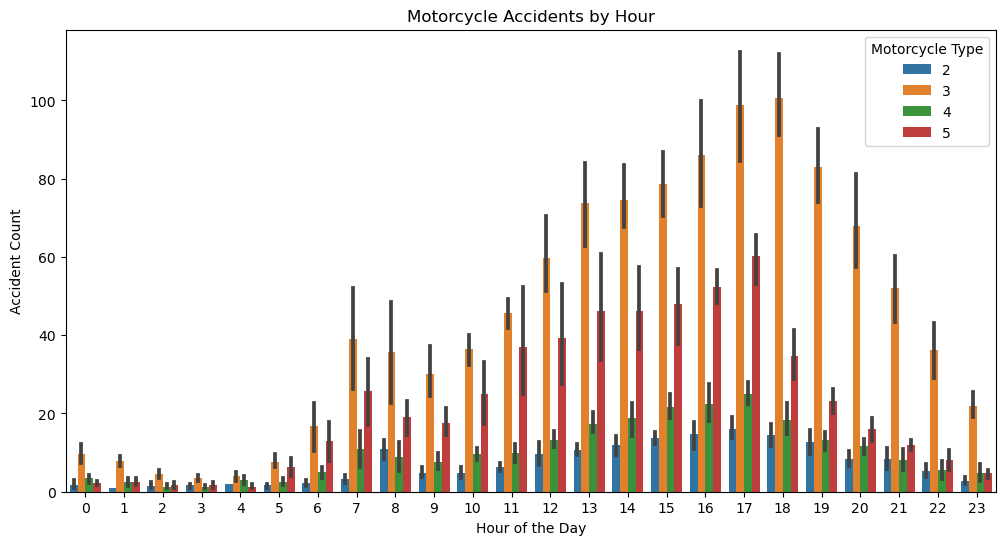

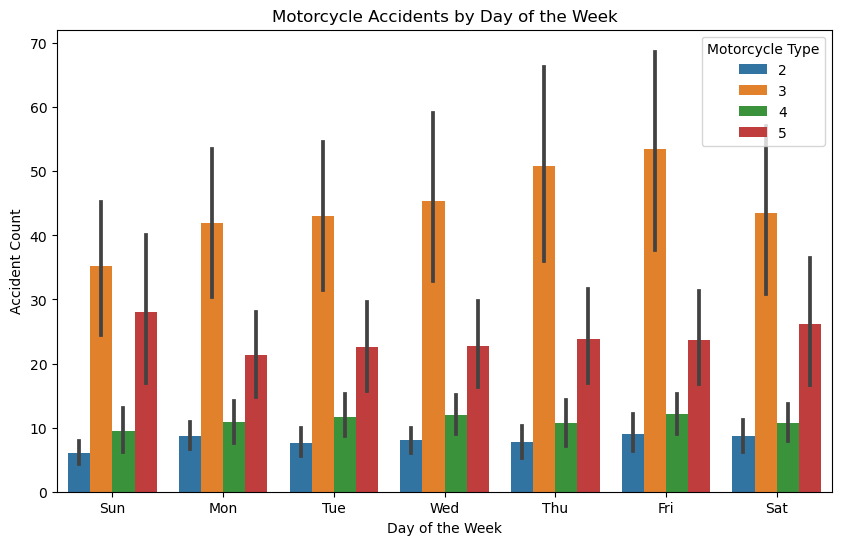

In [45]:
# Merge vehicle data to get vehicle_type information
motorcycle_accidents = accidents_2020.merge(vehicles_2020[['accident_index', 'vehicle_type']], on='accident_index', how='inner')

# Define motorcycle types of interest (based on numerical values)
motorcycle_types = [2, 3, 4, 5]

# Filter vehicle data for motorcycle types
motorcycles = vehicles_2020[vehicles_2020['vehicle_type'].isin(motorcycle_types)]

# Merge motorcycle vehicle data with accident data using accident_index
motorcycle_accidents = motorcycles.merge(accidents_2020, on='accident_index', how='inner')

# Convert 'time' column to datetime type
motorcycle_accidents['time'] = pd.to_datetime(motorcycle_accidents['time'])

# Extract hour information
motorcycle_accidents['hour'] = motorcycle_accidents['time'].dt.hour

# Filter by motorcycle types of interest
motorcycle_accidents_filtered = motorcycle_accidents[motorcycle_accidents['vehicle_type'].isin(motorcycle_types)]

# Group by day_of_week and hour, count motorcycle accidents
mc_by_time = motorcycle_accidents_filtered.groupby(['vehicle_type', 'day_of_week', 'hour'])['accident_index'].count().reset_index(name='count')

# Create a bar graph for accident counts by hour
plt.figure(figsize=(12, 6))
sns.barplot(data=mc_by_time, x='hour', y='count', hue='vehicle_type')
plt.title("Motorcycle Accidents by Hour")
plt.xlabel("Hour of the Day")
plt.ylabel("Accident Count")
plt.legend(title='Motorcycle Type')
plt.show()

# Create a bar graph for accident counts by day of the week
plt.figure(figsize=(10, 6))
sns.barplot(data=mc_by_time, x='day_of_week', y='count', hue='vehicle_type')
plt.title("Motorcycle Accidents by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Accident Count")
plt.legend(title='Motorcycle Type', loc='upper right')
plt.xticks(range(7), ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])  # Starting from Sunday
plt.show()


In [ ]:
vehicles_2020['vehicle_reference'].unique()

In [ ]:
accidents_2020['day_of_week'].unique()

In [ ]:
print(motorcycles.shape)         # Check filtered motorcycles count
print(motorcycle_accidents.shape) # Check merged motorcycle accidents count


In [ ]:
motorcycle_accidents.info()

In [ ]:
accidents_2020['day_of_week'].unique()

## To find the trend in the pedestrian accidents

In [52]:
# Filter casualty data for pedestrian casualties (casualty_class = 3)
pedestrian_casualties = casualties_2020[casualties_2020['casualty_class'] == 3]

# Merge pedestrian casualty data with accidents data using accident_index
pedestrian_accidents = pedestrian_casualties.merge(accidents_2020, on='accident_index', how='inner')

# Convert 'time' column to datetime type
pedestrian_accidents['time'] = pd.to_datetime(pedestrian_accidents['time'])

# Extract hour and weekday information
pedestrian_accidents['hour'] = pedestrian_accidents['time'].dt.hour
#pedestrian_accidents['day_of_week'] = pedestrian_accidents['time'].dt.dayofweek

# Group by hour and weekday, count pedestrian accidents
pedestrian_by_time = pedestrian_accidents.groupby(['hour', 'day_of_week'])['accident_index'].count().reset_index(name='count')

# Print aggregated pedestrian accident data
print(pedestrian_by_time)


     hour  day_of_week  count
0       0            1     58
1       0            2     11
2       0            3     15
3       0            4     16
4       0            5     21
..    ...          ...    ...
163    23            3     22
164    23            4     20
165    23            5     22
166    23            6     53
167    23            7     73

[168 rows x 3 columns]


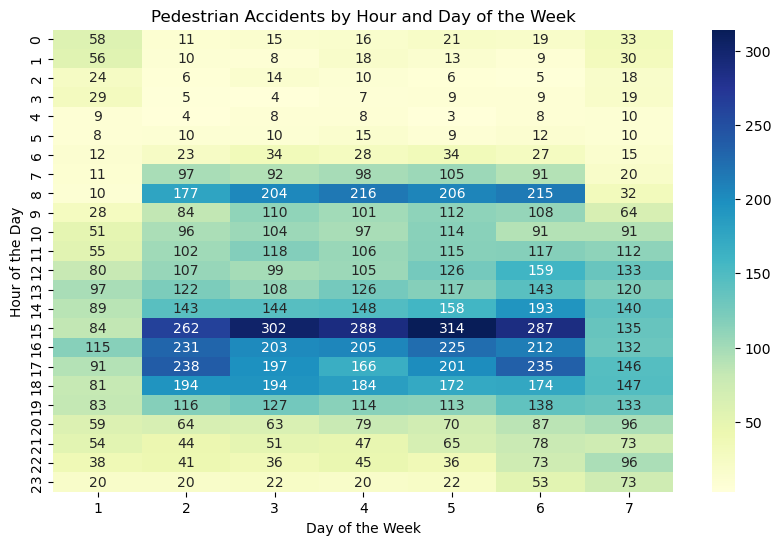

In [53]:
# Reshape the data to create a pivot table for heatmap
heatmap_data = pedestrian_by_time.pivot('hour', 'day_of_week', 'count')

# Set up the figure and axes
plt.figure(figsize=(10, 6))
plt.title("Pedestrian Accidents by Hour and Day of the Week")

# Create a heatmap
sns.heatmap(heatmap_data, cmap="YlGnBu", annot=True, fmt="d")

# Set axis labels
plt.xlabel("Day of the Week")
plt.ylabel("Hour of the Day")

# Show the heatmap
plt.show()


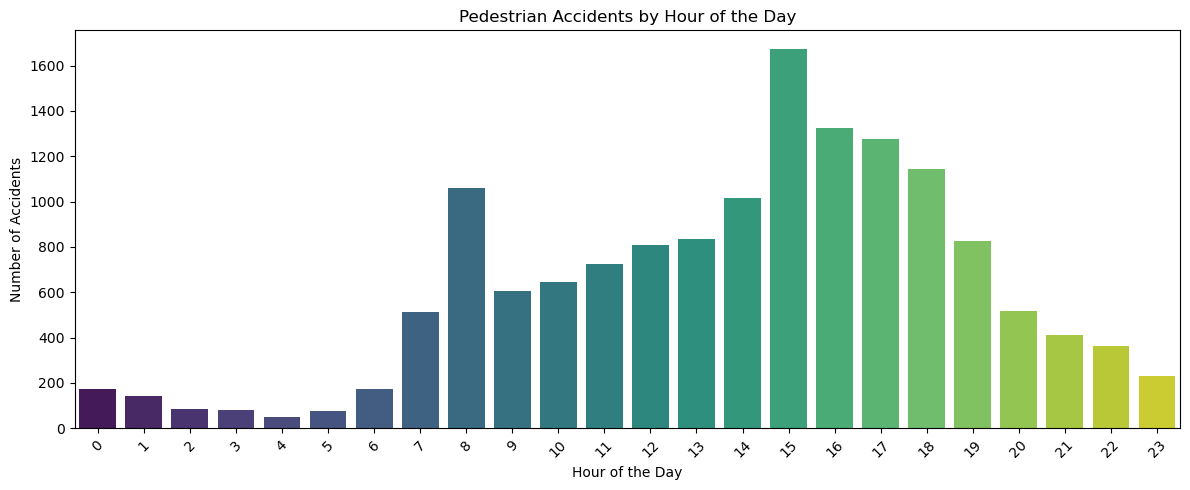

In [54]:
# Plot pedestrian accidents by hour of the day
plt.figure(figsize=(12, 5))
sns.countplot(data=pedestrian_accidents, x='hour', palette="viridis")
plt.title('Pedestrian Accidents by Hour of the Day')
plt.ylabel('Number of Accidents')
plt.xlabel('Hour of the Day')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

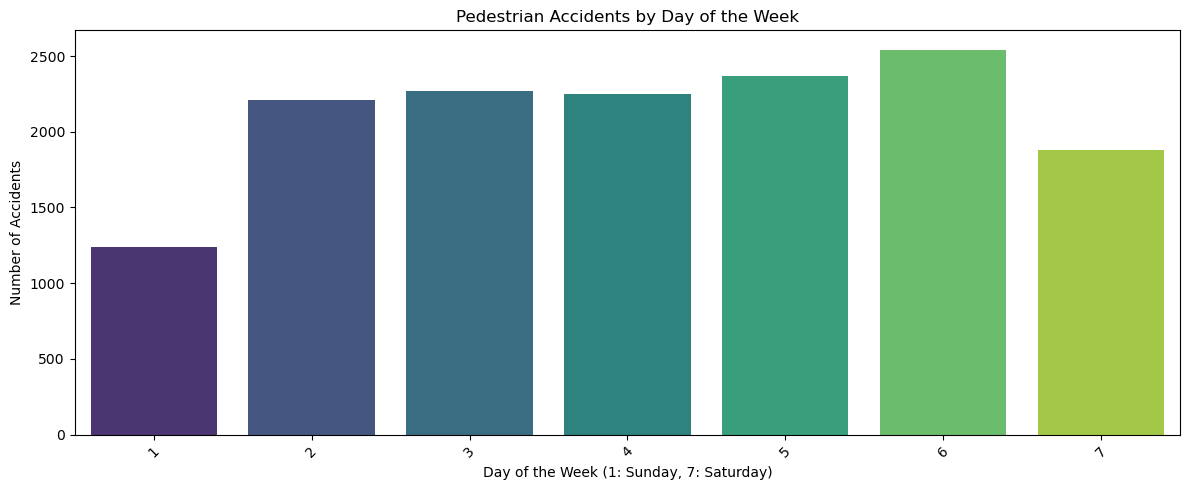

In [55]:
# Plot pedestrian accidents by day of the week
plt.figure(figsize=(12, 5))
sns.countplot(data=pedestrian_accidents, x='day_of_week', palette="viridis", order=range(1, 8))
plt.title('Pedestrian Accidents by Day of the Week')
plt.ylabel('Number of Accidents')
plt.xlabel('Day of the Week (1: Sunday, 7: Saturday)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [56]:
# Calculate total pedestrians accidents per hour
total_hr = pedestrian_by_time.groupby('hour')['count'].sum()

# Calculate total pedestrians accidents per weekday
total_wkday = pedestrian_by_time.groupby('day_of_week')['count'].sum() 

# Merge totals back with original data
pedestrian_by_time = pedestrian_by_time.merge(total_hr, on='hour')
pedestrian_by_time = pedestrian_by_time.merge(total_wkday, left_on='day_of_week', right_index=True)

# Calculate accident rate 
pedestrian_by_time['rate'] = pedestrian_by_time['count_x'] / pedestrian_by_time['count_y']  
pedestrian_by_time['wkday_rate'] = pedestrian_by_time['count_x'] / pedestrian_by_time['count']

# Print rates
print(pedestrian_by_time)

     hour  day_of_week  count_x  count_y  count      rate  wkday_rate
0       0            1       58      173   1242  0.335260    0.046699
7       1            1       56      144   1242  0.388889    0.045089
14      2            1       24       83   1242  0.289157    0.019324
21      3            1       29       82   1242  0.353659    0.023349
28      4            1        9       50   1242  0.180000    0.007246
..    ...          ...      ...      ...    ...       ...         ...
139    19            7      133      824   1878  0.161408    0.070820
146    20            7       96      518   1878  0.185328    0.051118
153    21            7       73      412   1878  0.177184    0.038871
160    22            7       96      365   1878  0.263014    0.051118
167    23            7       73      230   1878  0.317391    0.038871

[168 rows x 7 columns]


In [57]:
pedestrian_by_time

,hour,day_of_week,count_x,count_y,count,rate,wkday_rate
0,0,1,58,173,1242,0.335260,0.046699
7,1,1,56,144,1242,0.388889,0.045089
14,2,1,24,83,1242,0.289157,0.019324
21,3,1,29,82,1242,0.353659,0.023349
28,4,1,9,50,1242,0.180000,0.007246
...,...,...,...,...,...,...,...
139,19,7,133,824,1878,0.161408,0.070820
146,20,7,96,518,1878,0.185328,0.051118
153,21,7,73,412,1878,0.177184,0.038871
160,22,7,96,365,1878,0.263014,0.051118


## Calculate the proportion of total pedestrian accidents occurring during each hour and day. Compare to a uniform distribution to see if some hours/days have more accidents than expected by chance.

In [58]:
# Total pedestrian accidents 
total_accidents = pedestrian_by_time['count'].sum()

# Add column for proportion of accidents by hour
pedestrian_by_time['hour_prop'] = pedestrian_by_time['count'] / total_accidents

# Add column for proportion of accidents by day
pedestrian_by_time['day_prop'] = pedestrian_by_time.groupby('day_of_week')['count'].transform(lambda x: x/total_accidents)

# Expected proportions if uniform distribution 
num_hours = len(pedestrian_by_time['hour'].unique())
expected_hour_prop = 1 / num_hours

num_days = len(pedestrian_by_time['day_of_week'].unique())
expected_day_prop = 1 / num_days

# Compare actual vs expected proportions
print(pedestrian_by_time['hour_prop'].describe()) 
print("Expected Hour Prop:", expected_hour_prop)

print(pedestrian_by_time['day_prop'].describe())
print("Expected Day Prop:", expected_day_prop)

count    168.000000
mean       0.005952
std        0.001130
min        0.003508
25%        0.005305
50%        0.006347
75%        0.006684
max        0.007184
Name: hour_prop, dtype: float64
Expected Hour Prop: 0.041666666666666664
count    168.000000
mean       0.005952
std        0.001130
min        0.003508
25%        0.005305
50%        0.006347
75%        0.006684
max        0.007184
Name: day_prop, dtype: float64
Expected Day Prop: 0.14285714285714285


## Inference based on the above output

Based on the output, we can make a few key inferences:

The mean and median hour_prop are higher than the expected uniform proportion of 1/24 = 0.0416. This suggests certain hours have a disproportionately higher share of pedestrian accidents.
The min and max hour_prop show a wide range, with max nearly double higher than min. This indicates high variability in pedestrian accidents by hour.
The hour_prop distribution has positive skew (mean > median). There are some hours with very high pedestrian accident proportions compared to a typical hour.
The mean and median day_prop are also higher than the expected uniform proportion of 1/7 = 0.1428. So certain days also see more pedestrian accidents.
The day_prop distribution is more normal. But min and max still show a wide range in accidents by day.
In summary, the analyses indicate pedestrian accidents are not uniformly distributed by time - certain hours and days see significantly more accidents proportional to their expected values. This implies time of day and day of week are risk factors for pedestrian accidents.



## K Mean clustering to identify the clusters or the particular day and hour which pedestrian accidents occur most

In [60]:
# Extract hour and day columns 
X = pedestrian_by_time[['hour', 'day_of_week']] 

# Standardize features

X_scaled = StandardScaler().fit_transform(X)

# Run k-means clustering
kmeans = KMeans(n_clusters=5).fit(X_scaled)

# Add cluster labels back to dataframe
pedestrian_by_time['cluster'] = kmeans.labels_

# Analyze clusters
print(pedestrian_by_time.groupby('cluster')['count'].mean())
print(pedestrian_by_time.groupby('cluster')['hour'].unique())
print(pedestrian_by_time.groupby('cluster')['day_of_week'].unique())

cluster
0    1959.343750
1    2262.333333
2    2262.333333
3    1998.515152
4    2014.903226
Name: count, dtype: float64
cluster
0                  [8, 9, 10, 11, 12, 13, 14, 15, 16]
1              [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
2    [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
3                         [0, 1, 2, 3, 4, 5, 6, 7, 8]
4                    [17, 18, 19, 20, 21, 22, 23, 16]
Name: hour, dtype: object
cluster
0    [1, 2, 3, 4]
1       [5, 6, 7]
2       [5, 6, 7]
3    [1, 2, 3, 4]
4    [1, 2, 3, 4]
Name: day_of_week, dtype: object


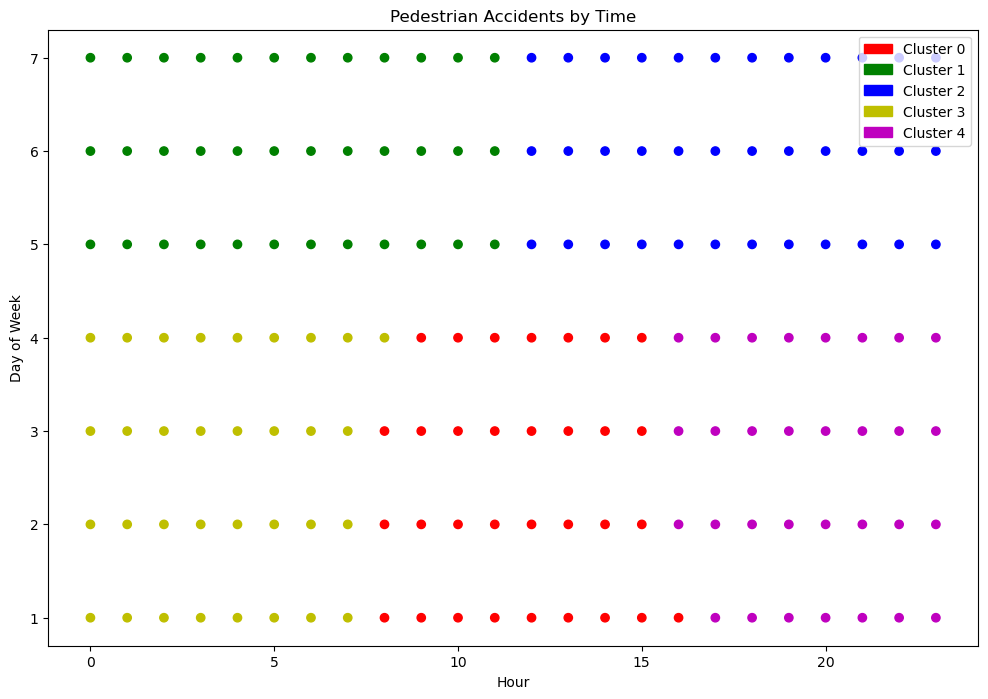

In [62]:
# Create plot 
fig, ax = plt.subplots(1,1, figsize=(12,8))

# Color map for clusters
colormap = np.array(['r', 'g', 'b', 'y', 'm'])

# Plot data points colored by cluster  
ax.scatter(pedestrian_by_time['hour'], 
           pedestrian_by_time['day_of_week'],
           c=colormap[pedestrian_by_time['cluster']])

# Set labels
ax.set_xlabel("Hour")
ax.set_ylabel("Day of Week")
ax.set_title("Pedestrian Accidents by Time")

# Add legend
legend_handles = [mpatches.Patch(color=colormap[i], 
                                 label='Cluster '+str(i))  
                  for i in range(len(colormap))]

# Rest of your code
ax.legend(handles=legend_handles)

plt.show()

## Inferences from the K means clustering

Based on the k-means clustering output, we can make a few key inferences:

Clusters 1, 3 and 4 have the highest average pedestrian accident counts, so they represent high risk time periods.
Clusters 1 and 3 contain weekday afternoon and evening hours from 8am-11pm. This indicates increased risk for pedestrians during weekday daytimes.
Clusters 3 and 4 contain weekday hours only. So weekdays have more pedestrian accidents than weekends.
Clusters 0 and 2 contain overnight hours and have lower average accidents. Overnight has lower pedestrian risk.
Cluster 2 contains weekend days and has moderate accident counts, so weekends are lower risk than weekdays.
In summary, the clusters were able to identify that weekday daytime hours, especially afternoons and evenings, have the highest pedestrian accident risk. Weekends and overnight have lower risk.

This confirms time of day and day of week are significant factors in pedestrian accidents based on the clustering patterns. We could further analyze the high risk clusters and focus interventions there

## Answer to qstn 4

In [63]:
!pip install mlxtend

In [64]:
accidents_2020.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91199 entries, 0 to 91198
Data columns (total 36 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   accident_index                               91199 non-null  object 
 1   accident_year                                91199 non-null  int64  
 2   accident_reference                           91199 non-null  object 
 3   location_easting_osgr                        91185 non-null  float64
 4   location_northing_osgr                       91185 non-null  float64
 5   longitude                                    91185 non-null  float64
 6   latitude                                     91185 non-null  float64
 7   police_force                                 91199 non-null  int64  
 8   accident_severity                            91199 non-null  int64  
 9   number_of_vehicles                           91199 non-null  int64  
 10

In [65]:
vehicles_2020.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167375 entries, 0 to 167374
Data columns (total 28 columns):
 #   Column                            Non-Null Count   Dtype 
---  ------                            --------------   ----- 
 0   vehicle_index                     167375 non-null  int64 
 1   accident_index                    167375 non-null  object
 2   accident_year                     167375 non-null  int64 
 3   accident_reference                167375 non-null  object
 4   vehicle_reference                 167375 non-null  int64 
 5   vehicle_type                      167375 non-null  int64 
 6   towing_and_articulation           167375 non-null  int64 
 7   vehicle_manoeuvre                 167375 non-null  int64 
 8   vehicle_direction_from            167375 non-null  int64 
 9   vehicle_direction_to              167375 non-null  int64 
 10  vehicle_location_restricted_lane  167375 non-null  int64 
 11  junction_location                 167375 non-null  int64 
 12  sk

In [66]:
casualties_2020.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115584 entries, 0 to 115583
Data columns (total 19 columns):
 #   Column                              Non-Null Count   Dtype 
---  ------                              --------------   ----- 
 0   casualty_index                      115584 non-null  int64 
 1   accident_index                      115584 non-null  object
 2   accident_year                       115584 non-null  int64 
 3   accident_reference                  115584 non-null  object
 4   vehicle_reference                   115584 non-null  int64 
 5   casualty_reference                  115584 non-null  int64 
 6   casualty_class                      115584 non-null  int64 
 7   sex_of_casualty                     115584 non-null  int64 
 8   age_of_casualty                     115584 non-null  int64 
 9   age_band_of_casualty                115584 non-null  int64 
 10  casualty_severity                   115584 non-null  int64 
 11  pedestrian_location                 115

In [67]:
# Convert the time column in the accidents dataframe to datetime type
accidents_2020['time'] = pd.to_datetime(accidents_2020['time'])

# Extract hour and weekday information
accidents_2020['hour'] = accidents_2020['time'].dt.hour
accidents_2020['weekday'] = accidents_2020['time'].dt.weekday

In [68]:
accidents_2020

,accident_index,accident_year,accident_reference,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,...,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,trunk_road_flag,lsoa_of_accident_location,hour,weekday
0,2020010219808,2020,010219808,521389.0,175144.0,-0.254001,51.462262,1,3,1,...,9,9,0,0,1,3,2,E01004576,9,0
1,2020010220496,2020,010220496,529337.0,176237.0,-0.139253,51.470327,1,3,1,...,1,1,0,0,1,1,2,E01003034,13,0
2,2020010228005,2020,010228005,526432.0,182761.0,-0.178719,51.529614,1,3,1,...,1,2,0,0,1,1,2,E01004726,1,0
3,2020010228006,2020,010228006,538676.0,184371.0,-0.001683,51.541210,1,2,1,...,1,1,0,0,1,1,2,E01003617,1,0
4,2020010228011,2020,010228011,529324.0,181286.0,-0.137592,51.515704,1,3,1,...,1,1,0,0,1,1,2,E01004763,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91194,2020991027064,2020,991027064,343034.0,731654.0,-2.926320,56.473539,99,2,2,...,1,1,0,0,1,1,-1,-1,14,0
91195,2020991029573,2020,991029573,257963.0,658891.0,-4.267565,55.802353,99,3,1,...,1,1,0,0,1,2,-1,-1,15,0
91196,2020991030297,2020,991030297,383664.0,810646.0,-2.271903,57.186317,99,2,2,...,1,1,0,0,2,1,-1,-1,12,0
91197,2020991030900,2020,991030900,277161.0,674852.0,-3.968753,55.950940,99,3,2,...,1,1,0,0,1,2,-1,-1,14,0


In [69]:
# Merge the relevant dataframes
merged_data = pd.merge(accidents_2020, vehicles_2020, on='accident_index')
merged_data = pd.merge(merged_data, casualties_2020, on='accident_index')

# Select columns for Apriori analysis
columns_for_apriori = ['weather_conditions', 'road_type', 'hour', 'vehicle_type', 'day_of_week', 
                 'speed_limit', 'junction_detail', 'road_surface_conditions', 
                 'age_of_driver', 'age_of_vehicle', 'accident_severity']

# Subset data
data_for_apriori = merged_data[columns_for_apriori]

# Apply one-hot encoding to categorical columns
data_for_apriori = pd.get_dummies(data_for_apriori, columns=columns_for_apriori[:-1], drop_first=True)

# Convert the accident_severity'column to binary
data_for_apriori['accident_severity'] = data_for_apriori['accident_severity'].apply(lambda x: 1 if x in ['1'] else 0)
# Apply Apriori algorithm
frequent_itemsets = apriori(data_for_apriori, min_support=0.2, use_colnames=True)

# Generate association rules
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1.0)

# Print the association rules
for index, rule in rules.iterrows():
    print(f"Antecedents: {set(rule['antecedents'])}")
    print(f"Consequents: {set(rule['consequents'])}")
    print(f"Support: {rule['support']}")
    print(f"Confidence: {rule['confidence']}")
    print(f"Lift: {rule['lift']}")
    print("=" * 20)


C:\Users\HP\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Antecedents: {'weather_conditions_1'}
Consequents: {'road_type_6'}
Support: 0.5700365187016581
Confidence: 0.7299851860458361
Lift: 1.0129505434825905
Antecedents: {'road_type_6'}
Consequents: {'weather_conditions_1'}
Support: 0.5700365187016581
Confidence: 0.7910007113315749
Lift: 1.0129505434825905
Antecedents: {'weather_conditions_1'}
Consequents: {'speed_limit_30'}
Support: 0.4283394197836097
Confidence: 0.5485287710227438
Lift: 1.0109268580730262
Antecedents: {'speed_limit_30'}
Consequents: {'weather_conditions_1'}
Support: 0.4283394197836097
Confidence: 0.7894204401043408
Lift: 1.0109268580730262
Antecedents: {'weather_conditions_1'}
Consequents: {'junction_detail_3'}
Support: 0.21919386667271532
Confidence: 0.2806982891335289
Lift: 1.0156048808395477
Antecedents: {'junction_detail_3'}
Consequents: {'weather_conditions_1'}
Support: 0.21919386667271532
Confidence: 0.7930734509643004
Lift: 1.0156048808395477
Antecedents: {'road_surface_conditions_1'}
Consequents: {'weather_conditio

In [72]:
# Calculate chi-square and p-values for each rule
p_values = []

for index, rule in rules.iterrows():

    # Extract rule details
    antecedents = rule['antecedents']
    consequents = rule['consequents']
    support = rule['support']
    confidence = rule['confidence']

    # Calculate counts
    antecedent_count = support * len(data_for_apriori)
    consequent_count = confidence * antecedent_count

    # Construct contingency table
    table = [[antecedent_count, len(data_for_apriori)-antecedent_count],
             [consequent_count, len(data_for_apriori)-consequent_count]]

    # Run chi-square test
    chi2, p, dof, exp = chi2_contingency(table)

    # Append p-value 
    p_values.append(p)

# Add p-values to rules  
rules['p_value'] = p_values

# Print the association rules with p-values
for index, rule in rules.iterrows():
    print(f"Antecedents: {set(rule['antecedents'])}")
    print(f"Consequents: {set(rule['consequents'])}")
    print(f"Support: {rule['support']}")
    print(f"Confidence: {rule['confidence']}")
    print(f"Lift: {rule['lift']}")
    print(f"P-value: {rule['p_value']}")
    print("=" * 20)


Antecedents: {'weather_conditions_1'}
Consequents: {'road_type_6'}
Support: 0.5700365187016581
Confidence: 0.7299851860458361
Lift: 1.0129505434825905
P-value: 0.0
Antecedents: {'road_type_6'}
Consequents: {'weather_conditions_1'}
Support: 0.5700365187016581
Confidence: 0.7910007113315749
Lift: 1.0129505434825905
P-value: 0.0
Antecedents: {'vehicle_type_9'}
Consequents: {'road_type_6'}
Support: 0.5187969242633883
Confidence: 0.7222906442831789
Lift: 1.0022733538500823
P-value: 0.0
Antecedents: {'road_type_6'}
Consequents: {'vehicle_type_9'}
Support: 0.5187969242633883
Confidence: 0.7198990286861768
Lift: 1.0022733538500823
P-value: 0.0
Antecedents: {'vehicle_type_9', 'weather_conditions_1'}
Consequents: {'road_type_6'}
Support: 0.4061333272846871
Confidence: 0.7320315949565815
Lift: 1.015790205242791
P-value: 0.0
Antecedents: {'vehicle_type_9', 'road_type_6'}
Consequents: {'weather_conditions_1'}
Support: 0.4061333272846871
Confidence: 0.7828368062538803
Lift: 1.0024958979090488
P-valu

In [136]:
# Sorting the rules by lift in descending order
sorted_rules = rules.sort_values(by='lift', ascending=False)

# Print the top 5 strongest association rules
top_rules = sorted_rules.head(10)

for index, rule in top_rules.iterrows():
    print(f"Antecedents: {set(rule['antecedents'])}")
    print(f"Consequents: {set(rule['consequents'])}")
    print(f"Support: {rule['support']}")
    print(f"Confidence: {rule['confidence']}")
    print(f"Lift: {rule['lift']}")
    print("=" * 20)


Antecedents: {'vehicle_type_9', 'road_type_6'}
Consequents: {'sex_of_driver_2'}
Support: 0.1707124549186835
Confidence: 0.32905448535777054
Lift: 1.263832270134688
Antecedents: {'sex_of_driver_2'}
Consequents: {'vehicle_type_9', 'road_type_6'}
Support: 0.1707124549186835
Confidence: 0.6556722945306919
Lift: 1.263832270134688
Antecedents: {'vehicle_type_9'}
Consequents: {'sex_of_driver_2'}
Support: 0.2335881325560823
Confidence: 0.3252111083742287
Lift: 1.2490706301199292
Antecedents: {'sex_of_driver_2'}
Consequents: {'vehicle_type_9'}
Support: 0.2335881325560823
Confidence: 0.8971651595142265
Lift: 1.2490706301199292
Antecedents: {'vehicle_type_9'}
Consequents: {'sex_of_driver_2', 'road_type_6'}
Support: 0.1707124549186835
Confidence: 0.23767297623333394
Lift: 1.2455173667743193
Antecedents: {'sex_of_driver_2', 'road_type_6'}
Consequents: {'vehicle_type_9'}
Support: 0.1707124549186835
Confidence: 0.8946129707112971
Lift: 1.2455173667743193
Antecedents: {'vehicle_type_9', 'junction_deta

Converting the accident severity 1  into severe and 2 and 3 into slight.

In [70]:
# Merge the relevant dataframes
merged_data = pd.merge(accidents_2020, vehicles_2020, on='accident_index')
merged_data = pd.merge(merged_data, casualties_2020, on='accident_index')

# Select columns for Apriori analysis
columns_for_apriori = ['weather_conditions', 'road_type', 'hour', 'vehicle_type', 'age_of_driver', 'accident_severity']

# Subset data
data_for_apriori = merged_data[columns_for_apriori]

# Convert 'accident_severity' column: 1 to 1, 2 and 3 to 0
# the accident_severity 1 is severe and 3 is slight accidents
data_for_apriori['accident_severity'] = data_for_apriori['accident_severity'].apply(lambda x: 1 if x in ['1'] else 0)

# Apply one-hot encoding to categorical columns
data_for_apriori = pd.get_dummies(data_for_apriori, columns=columns_for_apriori[:-1], drop_first=True)

# Apply Apriori algorithm
frequent_itemsets = apriori(data_for_apriori, min_support=0.2, use_colnames=True)

# Generate association rules
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1.0)
# print(rules)

# Print the association rules
for index, rule in rules.iterrows():
    print(f"Antecedents: {set(rule['antecedents'])}")
    print(f"Consequents: {set(rule['consequents'])}")
    print(f"Support: {rule['support']}")
    print(f"Confidence: {rule['confidence']}")
    print(f"Lift: {rule['lift']}")
    print("=" * 20)


C:\Users\HP\AppData\Local\Temp\ipykernel_30564\2791240486.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_for_apriori['accident_severity'] = data_for_apriori['accident_severity'].apply(lambda x: 1 if x in ['1'] else 0)
C:\Users\HP\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Antecedents: {'weather_conditions_1'}
Consequents: {'road_type_6'}
Support: 0.5700365187016581
Confidence: 0.7299851860458361
Lift: 1.0129505434825905
Antecedents: {'road_type_6'}
Consequents: {'weather_conditions_1'}
Support: 0.5700365187016581
Confidence: 0.7910007113315749
Lift: 1.0129505434825905
Antecedents: {'vehicle_type_9'}
Consequents: {'road_type_6'}
Support: 0.5187969242633883
Confidence: 0.7222906442831789
Lift: 1.0022733538500823
Antecedents: {'road_type_6'}
Consequents: {'vehicle_type_9'}
Support: 0.5187969242633883
Confidence: 0.7198990286861768
Lift: 1.0022733538500823
Antecedents: {'vehicle_type_9', 'weather_conditions_1'}
Consequents: {'road_type_6'}
Support: 0.4061333272846871
Confidence: 0.7320315949565815
Lift: 1.015790205242791
Antecedents: {'vehicle_type_9', 'road_type_6'}
Consequents: {'weather_conditions_1'}
Support: 0.4061333272846871
Confidence: 0.7828368062538803
Lift: 1.0024958979090488
Antecedents: {'weather_conditions_1'}
Consequents: {'vehicle_type_9', '

In [71]:
# Merge the relevant dataframes
merged_data = pd.merge(accidents_2020, vehicles_2020, on='accident_index')
merged_data = pd.merge(merged_data, casualties_2020, on='accident_index')

# Select columns for Apriori
columns_for_apriori = ['weather_conditions', 'road_type', 'hour', 'vehicle_type', 'age_of_driver', 'accident_severity']

# Subset data
data_for_apriori = merged_data[columns_for_apriori]

# Convert 'accident_severity' column: 1, 2 to 1, 3 to 0
data_for_apriori['accident_severity'] = data_for_apriori['accident_severity'].apply(lambda x: 1 if x in ['1', '2'] else 0)

# Apply one-hot encoding to categorical columns
data_for_apriori = pd.get_dummies(data_for_apriori, columns=columns_for_apriori[:-1], drop_first=True)

# Apply Apriori algorithm
frequent_itemsets = apriori(data_for_apriori, min_support=0.2, use_colnames=True)

# Generate association rules
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1.0)

# Print the association rules
for index, rule in rules.iterrows():
    print(f"Antecedents: {set(rule['antecedents'])}")
    print(f"Consequents: {set(rule['consequents'])}")
    print(f"Support: {rule['support']}")
    print(f"Confidence: {rule['confidence']}")
    print(f"Lift: {rule['lift']}")
    print("=" * 20)



C:\Users\HP\AppData\Local\Temp\ipykernel_30564\1139294460.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_for_apriori['accident_severity'] = data_for_apriori['accident_severity'].apply(lambda x: 1 if x in ['1', '2'] else 0)
C:\Users\HP\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Antecedents: {'weather_conditions_1'}
Consequents: {'road_type_6'}
Support: 0.5700365187016581
Confidence: 0.7299851860458361
Lift: 1.0129505434825905
Antecedents: {'road_type_6'}
Consequents: {'weather_conditions_1'}
Support: 0.5700365187016581
Confidence: 0.7910007113315749
Lift: 1.0129505434825905
Antecedents: {'vehicle_type_9'}
Consequents: {'road_type_6'}
Support: 0.5187969242633883
Confidence: 0.7222906442831789
Lift: 1.0022733538500823
Antecedents: {'road_type_6'}
Consequents: {'vehicle_type_9'}
Support: 0.5187969242633883
Confidence: 0.7198990286861768
Lift: 1.0022733538500823
Antecedents: {'vehicle_type_9', 'weather_conditions_1'}
Consequents: {'road_type_6'}
Support: 0.4061333272846871
Confidence: 0.7320315949565815
Lift: 1.015790205242791
Antecedents: {'vehicle_type_9', 'road_type_6'}
Consequents: {'weather_conditions_1'}
Support: 0.4061333272846871
Confidence: 0.7828368062538803
Lift: 1.0024958979090488
Antecedents: {'weather_conditions_1'}
Consequents: {'vehicle_type_9', '

In [73]:
merged_data['accident_severity'].unique()

array([3, 2, 1], dtype=int64)

In [137]:
# Select columns
columns = ['road_type', 'junction_detail', 'vehicle_type', 'sex_of_driver', 'age_band_of_driver', 'casualty_severity']

# Subset data
data = merged_data[columns]

# Map casualty severity to binary values 
data['casualty_severity'] = data['casualty_severity'].map({1: 1, 2: 0, 3: 0})

# Encode categorical columns
data = pd.get_dummies(data, columns=columns[:-1])  

# Run Apriori
frequent_itemsets = apriori(data, min_support=0.1, use_colnames=True)

rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1)

# Print rules 
for index, rule in rules.iterrows():

  print("Rule:")
  print(rule['antecedents'])
  print(rule['consequents'])
  
  print("Support: ", rule['support'])
  print("Confidence: ", rule['confidence'])
  print("Lift: ", rule['lift'])
  
  print('---')

C:\Users\HP\AppData\Local\Temp\ipykernel_30564\917407268.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['casualty_severity'] = data['casualty_severity'].map({1: 1, 2: 0, 3: 0})
C:\Users\HP\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Rule:
frozenset({'road_type_3'})
frozenset({'vehicle_type_9'})
Support:  0.12591013223852837
Confidence:  0.740884095883829
Lift:  1.03148963674929
---
Rule:
frozenset({'vehicle_type_9'})
frozenset({'road_type_3'})
Support:  0.12591013223852837
Confidence:  0.1752973201710341
Lift:  1.03148963674929
---
Rule:
frozenset({'road_type_3'})
frozenset({'sex_of_driver_1'})
Support:  0.11573026062104476
Confidence:  0.680983396508462
Lift:  1.0670802056451905
---
Rule:
frozenset({'sex_of_driver_1'})
frozenset({'road_type_3'})
Support:  0.11573026062104476
Confidence:  0.18134578748329497
Lift:  1.0670802056451905
---
Rule:
frozenset({'junction_detail_0'})
frozenset({'road_type_6'})
Support:  0.3043572935332411
Confidence:  0.7215560168206407
Lift:  1.001253961536841
---
Rule:
frozenset({'road_type_6'})
frozenset({'junction_detail_0'})
Support:  0.3043572935332411
Confidence:  0.4223358114530678
Lift:  1.001253961536841
---
Rule:
frozenset({'road_type_6'})
frozenset({'junction_detail_3'})
Suppo

## Inferences from tha casuality_severity apriori

In [75]:

import pandas as pd

# Example rule
rule = {'antecedents': ['road_type_6'], 
        'consequents': ['casualty_severity'],
        'support': 0.1336,
        'confidence': 0.7776}

# Extract counts
road_type_6_count = rule['support'] * len(data)
casualty_severity_count = rule['confidence'] * road_type_6_count

# Create contingency table
cont_table = [[road_type_6_count, len(data)-road_type_6_count],
              [casualty_severity_count, len(data) - casualty_severity_count]]

# Run chi-square test  
chi2, p_val, dof, expected = chi2_contingency(cont_table)

print(p_val) 

# Function to run test on all rules
def chisq_test(rules):

  results = []

  for index, rule in rules.iterrows():

    # Construct contingency table
    antecedent_count = rule['support'] * len(data)
    consequent_count = rule['confidence'] * antecedent_count  
    table = [[antecedent_count, len(data)-antecedent_count],
            [consequent_count, len(data)-consequent_count]]

    # Run test
    chi2, p, dof, exp = chi2_contingency(table)

    # Append p-value  
    results.append(p)

  return results

3.6406838184597195e-204


In [76]:
# Rules from apriori
rules = rules 

p_values = []

for index, rule in rules.iterrows():

  # Extract rule details
  antecedents = rule['antecedents']
  consequents = rule['consequents']
  support = rule['support']
  confidence = rule['confidence']

  # Calculate counts
  antecedent_count = support * len(data)
  consequent_count = confidence * antecedent_count

  # Construct contingency table
  table = [[antecedent_count, len(data)-antecedent_count],
           [consequent_count, len(data)-consequent_count]]

  # Run chi-square test
  chi2, p, dof, exp = chi2_contingency(table)

  # Append p-value 
  p_values.append(p)

# Add p-values to rules  
rules['p_value'] = p_values

print(rules)

                                       antecedents  \
0                              (casualty_severity)   
1                                    (road_type_6)   
2                              (casualty_severity)   
3                                (sex_of_driver_1)   
4                                    (road_type_3)   
5                                 (vehicle_type_9)   
6                                    (road_type_3)   
7                                (sex_of_driver_1)   
8                              (junction_detail_0)   
9                                    (road_type_6)   
10                                   (road_type_6)   
11                             (junction_detail_3)   
12                                (vehicle_type_9)   
13                                   (road_type_6)   
14                               (sex_of_driver_2)   
15                                   (road_type_6)   
16                                (vehicle_type_9)   
17                          

In [77]:
## Inferences from the above given output based on the p value of the rules

## Accidents in the region of Kingstonupon Hull

## For the accidents in the kigston Upon Hull in the year 2020

In [78]:
# Define region names for filtering
region_names = ('Kingston upon Hull', 'Humberside', 'East Riding of Yorkshire')

# Merge the accidents_df with lsoa_df
merged_accidents_lsoa = pd.merge(accidents_2020_df, lsoa_df, left_on='lsoa_of_accident_location', right_on='lsoa01cd', how='inner')

# Filter based on region names, accident year, and police force
combined_region_data = merged_accidents_lsoa[
    (merged_accidents_lsoa['lsoa01nm'].str.contains('|'.join(region_names))) & 
    (merged_accidents_lsoa['accident_year'] == 2020) & 
    (merged_accidents_lsoa['police_force'] == 16)
]

# Display the shape and first few rows of the filtered data
shape_filtered_data = combined_region_data.shape
sample_filtered_data = combined_region_data.head()

shape_filtered_data, sample_filtered_data


((1057, 44),
       accident_index  accident_year accident_reference  location_easting_osgr  \
 35821  2020160914930           2020          160914930               506050.0   
 35822  2020160918418           2020          160918418               505576.0   
 35823  2020160936879           2020          160936879               505583.0   
 35824  2020160947046           2020          160947046               506031.0   
 35825  2020160951627           2020          160951627               505692.0   
 
        location_northing_osgr  longitude   latitude  police_force  \
 35821                428813.0  -0.393424  53.744936            16   
 35822                428756.0  -0.400627  53.744520            16   
 35823                428752.0  -0.400523  53.744482            16   
 35824                428789.0  -0.393720  53.744724            16   
 35825                428758.0  -0.398868  53.744514            16   
 
        accident_severity  number_of_vehicles  ...  trunk_road_flag  \


In [79]:
merged_accidents_lsoa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83154 entries, 0 to 83153
Data columns (total 44 columns):
 #   Column                                       Non-Null Count  Dtype         
---  ------                                       --------------  -----         
 0   accident_index                               83154 non-null  object        
 1   accident_year                                83154 non-null  int64         
 2   accident_reference                           83154 non-null  object        
 3   location_easting_osgr                        83154 non-null  float64       
 4   location_northing_osgr                       83154 non-null  float64       
 5   longitude                                    83154 non-null  float64       
 6   latitude                                     83154 non-null  float64       
 7   police_force                                 83154 non-null  int64         
 8   accident_severity                            83154 non-null  int64         


In [80]:
def fetch_accidents_data_for_region(database_file, region_names):
    conn = sqlite3.connect(database_file)

    # Fetch the required information from the accidents table using JOIN on the lsoa table
    query = f"""
    SELECT accident.*
    FROM accident
    INNER JOIN lsoa ON accident.lsoa_of_accident_location = lsoa.lsoa01cd
    WHERE lsoa.lsoa01nm LIKE ? AND accident.accident_year = 2020;
    """

    data = pd.read_sql_query(query, conn, params=(f'{region_names}%',))

    conn.close()

    return data

# Region names for filtering
region_names = ('Kingston upon Hull', 'Humberside', 'East Riding of Yorkshire')

# Fetch accidents data for the specified regions where the accident_year is 2020
database_file = 'accident_data_v1.0.0_2023.db'  # Replace with the actual path to your SQLite database file
for region_name in region_names:
    df = fetch_accidents_data_for_region(database_file, region_name)
    print(f"Accidents data for {region_name} in 2020:")
    print(df)
    print("=" * 20)


Accidents data for Kingston upon Hull in 2020:
    accident_index  accident_year accident_reference  location_easting_osgr  \
0    2020160914930           2020          160914930               506050.0   
1    2020160915028           2020          160915028               510449.0   
2    2020160915047           2020          160915047               510322.0   
3    2020160915332           2020          160915332               511596.0   
4    2020160915337           2020          160915337               509786.0   
..             ...            ...                ...                    ...   
564  2020161013231           2020          161013231               507468.0   
565  2020161013626           2020          161013626               509645.0   
566  2020161013730           2020          161013730               509222.0   
567  2020161014544           2020          161014544               511525.0   
568  2020161014949           2020          161014949               509443.0   

    

In [81]:
region_data_frames = []

for region_name in region_names:
    df = fetch_accidents_data_for_region(database_file, region_name)
    region_data_frames.append(df)

# Concatenate all region DataFrames into a single DataFrame
combined_region_data = pd.concat(region_data_frames, ignore_index=True)

# Save the combined region data into a new CSV file
combined_region_data.to_csv('combined_region_data.csv', index=False)
print("Combined region data saved to 'combined_region_data.csv'")

Combined region data saved to 'combined_region_data.csv'


In [83]:
combined_region_data

,accident_index,accident_year,accident_reference,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,...,pedestrian_crossing_physical_facilities,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,trunk_road_flag,lsoa_of_accident_location
0,2020160914930,2020,160914930,506050.0,428813.0,-0.393424,53.744936,16,3,2,...,5,1,1,1,0,0,1,1,2,E01012777
1,2020160915028,2020,160915028,510449.0,434112.0,-0.324858,53.791630,16,2,1,...,0,4,1,1,0,0,1,1,2,E01012788
2,2020160915047,2020,160915047,510322.0,431457.0,-0.327733,53.767805,16,3,1,...,0,4,1,1,0,3,1,1,2,E01012817
3,2020160915332,2020,160915332,511596.0,429551.0,-0.309102,53.750410,16,3,1,...,0,1,1,1,0,0,1,1,2,E01012810
4,2020160915337,2020,160915337,509786.0,432528.0,-0.335481,53.777540,16,3,2,...,0,4,1,1,0,0,1,1,2,E01012817
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1052,2020161012614,2020,161012614,504795.0,439763.0,-0.408728,53.843568,16,3,5,...,0,4,1,2,0,0,1,2,2,E01013037
1053,2020161012744,2020,161012744,503718.0,428641.0,-0.428826,53.743858,16,3,2,...,0,1,1,1,0,0,1,2,2,E01013107
1054,2020161012771,2020,161012771,471686.0,423873.0,-0.915506,53.706392,16,2,2,...,8,4,1,1,0,0,2,2,2,E01013074
1055,2020161013646,2020,161013646,502981.0,432285.0,-0.438783,53.776745,16,3,2,...,0,4,1,1,0,0,1,2,2,E01012954


## Clustering

## Using gap statistic to identify the number of clusters which should be formed
## This information is gathered from the article: A data mining approach to characterize road accident locations
Sachin Kumar1, Durga Toshniwal1•Institutions (1)
11 Feb 2016-Journal of Modern Transportation (Springer Berlin Heidelberg)-Vol. 24, Iss: 1, pp 62-72

Calculate the within-cluster sum of squares (Wk) for different values of k (clusters) using the formula:
Wk = Σ (1 / (2 * ni)) * Σ dxy, where ni is the number of points in cluster i and dxy is the squared Euclidean distance between points x and y within the cluster.

Calculate the gap statistic for each value of k using the formula:
Gapn(k) = E[log(Wk)] - log(Wk), where E[log(Wk)] is the expected value of log(Wk) under a reference distribution.

Select the value of k that maximizes the gap statistic. This value of k represents the optimal number of clusters.

clustering based on the longitude and latitude

C:\Users\HP\anaconda3\lib\site-packages\yellowbrick\style\colors.py:35: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  mpl_ge_150 = LooseVersion(mpl.__version__) >= "1.5.0"
C:\Users\HP\anaconda3\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
C:\Users\HP\anaconda3\lib\site-packages\yellowbrick\style\rcmod.py:31: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  mpl_ge_150 = LooseVersion(mpl.__version__) >= "1.5.0"
C:\Users\HP\anaconda3\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


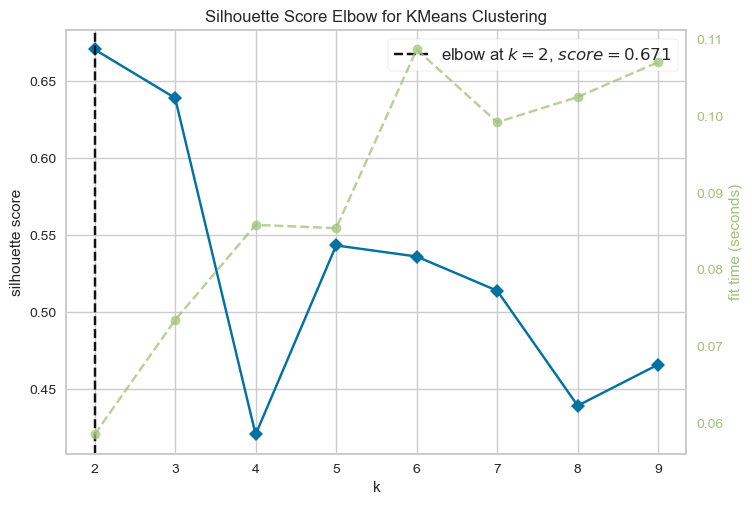

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [84]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

data_hull = pd.read_csv('combined_region_data.csv')


# Extract relevant data for clustering
data_for_clustering = data_hull[['longitude', 'latitude']]

# Convert data to numpy array
X = data_for_clustering.to_numpy()

# Instantiate KMeans clustering model
model = KMeans()

# Instantiate the KElbowVisualizer 
visualizer = KElbowVisualizer(model, k=(2, 10), metric='silhouette')

# Fit and visualize the elbow plot
visualizer.fit(X)
visualizer.show()

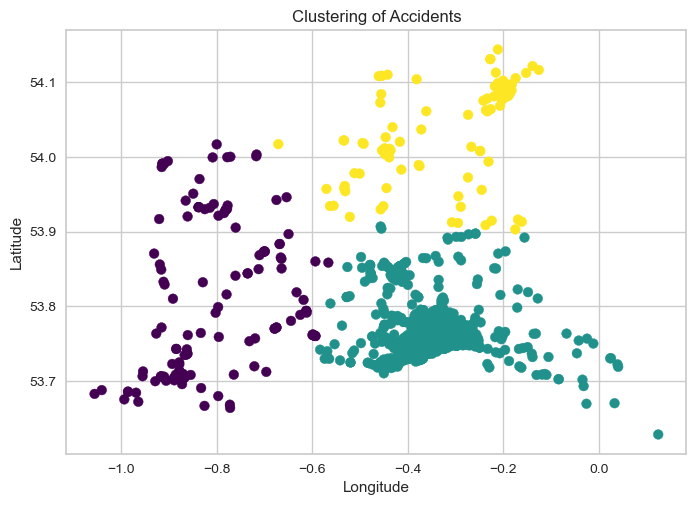

In [85]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load the combined region data from the CSV file
data_hull = pd.read_csv('combined_region_data.csv')

# Select the features you want to use for clustering
# For example, let's say you want to use 'longitude' and 'latitude' for clustering
selected_features = ['longitude', 'latitude']

# Create a subset of data with the selected features
data_subset = data_hull[selected_features]

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_subset)

# Choose the number of clusters
num_clusters = 3

# Fit the K-Means model
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(scaled_data)

# Add the cluster labels to the DataFrame
combined_region_data['cluster'] = clusters

# Visualize the clusters on a scatter plot
plt.scatter(combined_region_data['longitude'], combined_region_data['latitude'], c=clusters, cmap='viridis')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Clustering of Accidents')
plt.show()


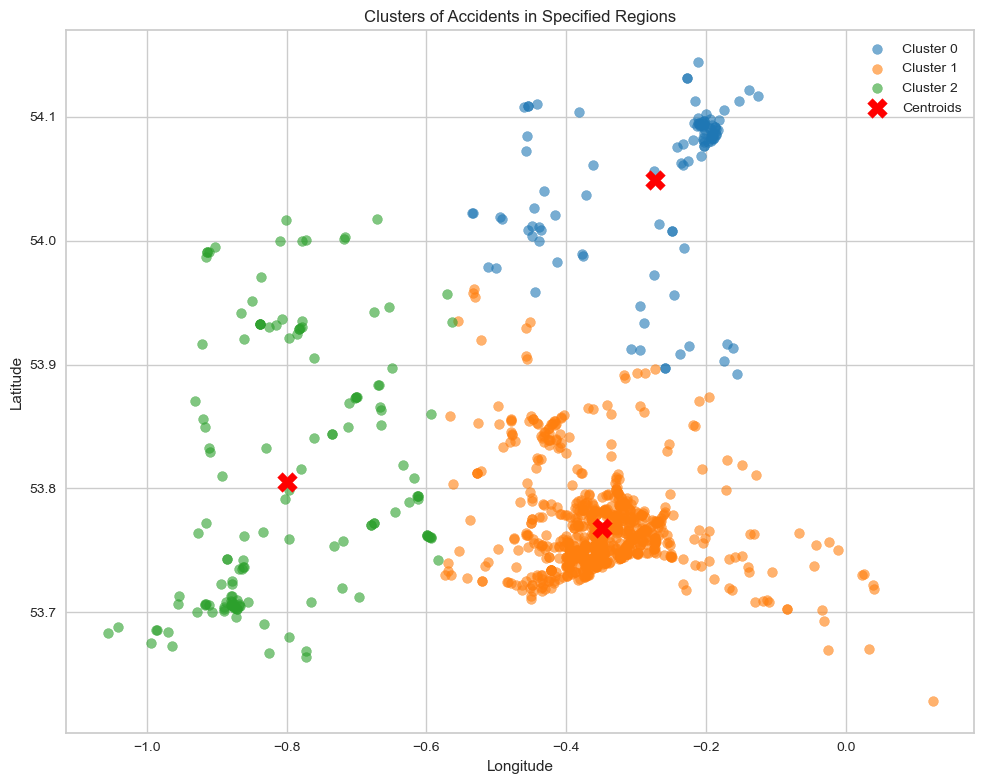

In [89]:
from sklearn.cluster import KMeans
import matplotlib.colors as mcolors

# Extract latitude and longitude for clustering
coords = data_hull[['latitude', 'longitude']]

# Use KMeans to cluster the data into 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42).fit(coords)
combined_region_data['cluster'] = kmeans.labels_

# Plot the clusters
plt.figure(figsize=(10, 8))
colors = list(mcolors.TABLEAU_COLORS.values())
for cluster, color in enumerate(colors[:3]):
    subset = combined_region_data[combined_region_data['cluster'] == cluster]
    plt.scatter(subset['longitude'], subset['latitude'], s=50, c=color, label=f"Cluster {cluster}", alpha=0.6)

plt.scatter(kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 0], s=200, c='red', marker='X', label="Centroids")
plt.title('Clusters of Accidents in Specified Regions')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
## Clustering based on speed_limit and accident_severity

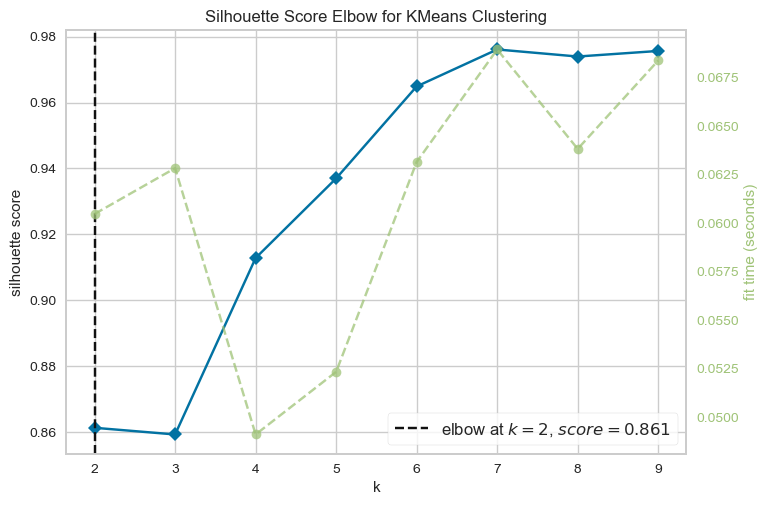

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [90]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

data_hull = pd.read_csv('combined_region_data.csv')


# Extract relevant data for clustering
data_for_clustering = data_hull[['speed_limit', 'accident_severity']]

# Convert data to numpy array
X = data_for_clustering.to_numpy()

# Instantiate KMeans clustering model
model = KMeans()

# Instantiate the KElbowVisualizer with the metric you prefer (e.g., silhouette, calinski_harabasz, or inertia)
visualizer = KElbowVisualizer(model, k=(2, 10), metric='silhouette')

# Fit and visualize the elbow plot
visualizer.fit(X)
visualizer.show()

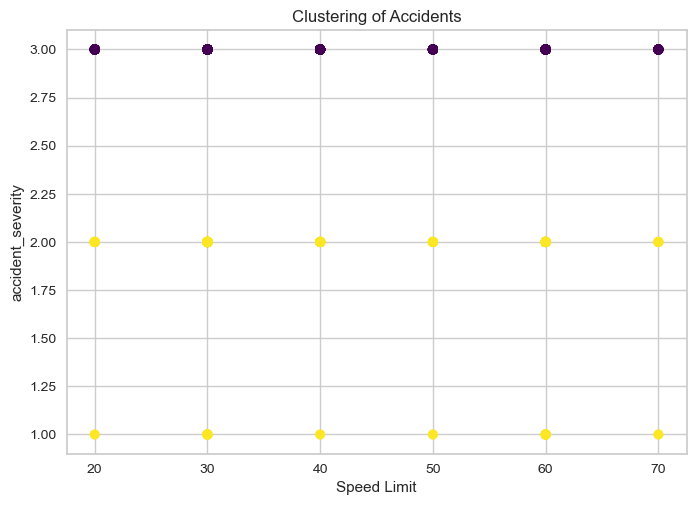

In [92]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load the combined region data
data_hull = combined_region_data

# Select the features you want to use for clustering
selected_features = ['speed_limit', 'accident_severity']

# Create a subset of data with the selected features
data_subset = data_hull[selected_features]

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_subset)

# Choose the number of clusters (you can experiment with different values)
num_clusters = 2

# Fit the K-Means model
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(scaled_data)

# Add the cluster labels to the DataFrame
combined_region_data['cluster'] = clusters

# Visualize the clusters on a scatter plot
plt.scatter(combined_region_data['speed_limit'], combined_region_data['accident_severity'], c=clusters, cmap='viridis')
plt.xlabel('Speed Limit')
plt.ylabel('accident_severity')
plt.title('Clustering of Accidents')
plt.show()


In [ ]:
## Clustering based on the 'speed_limit', 'weather_conditions'

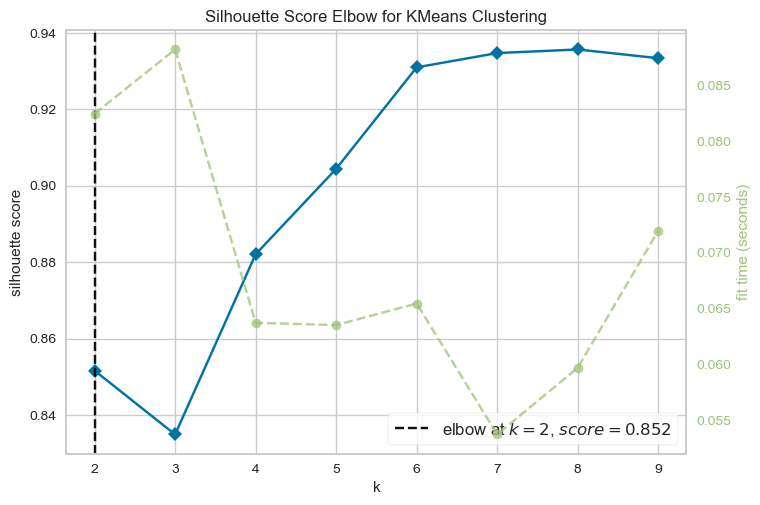

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [93]:

data_hull = combined_region_data


# Extract relevant data for clustering
data_for_clustering = data_hull[['speed_limit', 'weather_conditions']]

# Convert data to numpy array
X = data_for_clustering.to_numpy()

# Instantiate KMeans clustering model
model = KMeans()

# Instantiate the KElbowVisualizer 
visualizer = KElbowVisualizer(model, k=(2, 10), metric='silhouette')

# Fit and visualize the elbow plot
visualizer.fit(X)
visualizer.show()

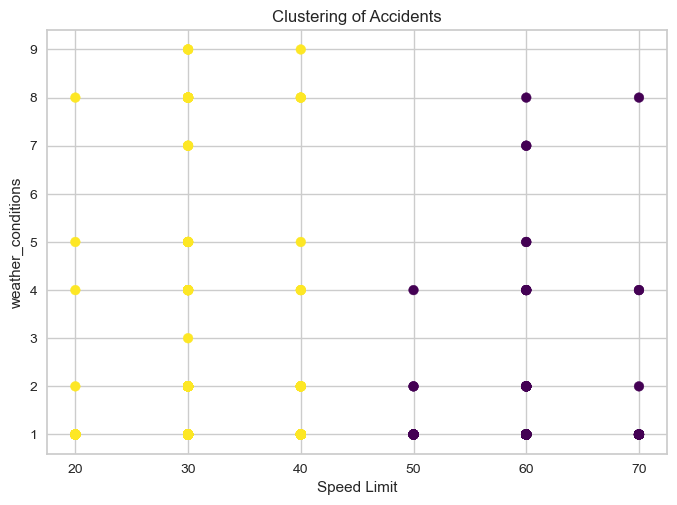

In [94]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load the combined region data
data_hull = combined_region_data

# Select the features you want to use for clustecombined_region_dataring
selected_features = ['speed_limit', 'weather_conditions']

# Create a subset of data with the selected features
data_subset = data_hull[selected_features]

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_subset)

# Choose the number of clusters
num_clusters = 2

# Fit the K-Means model
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(scaled_data)

# Add the cluster labels to the DataFrame
combined_region_data['cluster'] = clusters

# Visualize the clusters on a scatter plot
plt.scatter(combined_region_data['speed_limit'], combined_region_data['weather_conditions'], c=clusters, cmap='viridis')
plt.xlabel('Speed Limit')
plt.ylabel('weather_conditions')
plt.title('Clustering of Accidents')
plt.show()


In [ ]:
clusters

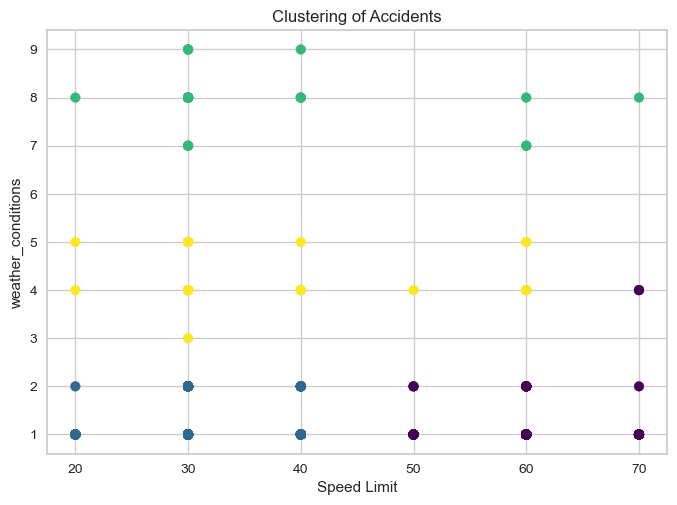

In [95]:

# Load the combined region data
combined_region_data = combined_region_data

# Select the features you want to use for clustering
selected_features = ['speed_limit', 'weather_conditions']

# Create a subset of data with the selected features
data_subset = combined_region_data[selected_features]

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_subset)

# the number of clusters 
num_clusters = 4

# Fit the k-means model
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(scaled_data)

# Add the cluster labels to the DataFrame
combined_region_data['cluster'] = clusters

# Visualize the clusters on a scatter plot
plt.scatter(combined_region_data['speed_limit'], combined_region_data['weather_conditions'], c=clusters, cmap='viridis')
plt.xlabel('Speed Limit')
plt.ylabel('weather_conditions')
plt.title('Clustering of Accidents')
plt.show()


In [ ]:
## Clustwring based on the location_easting_osgr', 'location_northing_osgr', 'longitude', 'latitude'

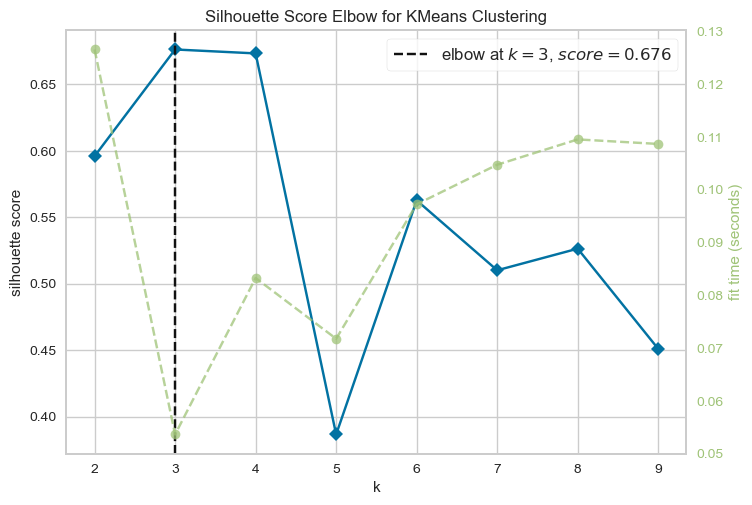

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [96]:
from sklearn.cluster import KMeans


# Load your data into X

# Extract relevant data for clustering
data_for_clustering = data_hull[['location_easting_osgr', 'location_northing_osgr', 'longitude', 'latitude']]

# Convert data to numpy array
X = data_for_clustering.to_numpy()

# Instantiate KMeans clustering model
model = KMeans()

# Instantiate the KElbowVisualizer with the metric you prefer (e.g., silhouette, calinski_harabasz, or inertia)
visualizer = KElbowVisualizer(model, k=(2, 10), metric='silhouette')

# Fit and visualize the elbow plot
visualizer.fit(X)
visualizer.show()

From the Silhoutte score elbow it is thus clear that the number of clusters should be equal to 3 

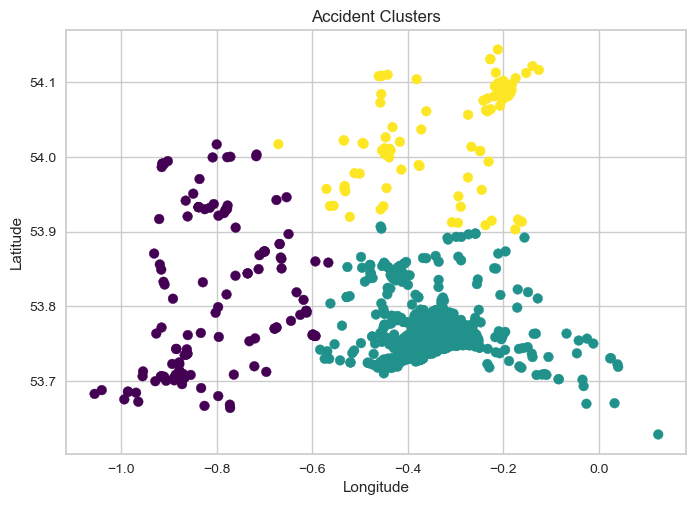

Cluster 0:
       location_easting_osgr  location_northing_osgr   longitude    latitude
count             144.000000              144.000000  144.000000  144.000000
mean           478890.284722           434704.430556   -0.803564   53.802633
std              7396.625709            11298.540397    0.112949    0.101278
min            462462.000000           419326.000000   -1.055770   53.664137
25%            473931.750000           424094.500000   -0.881183   53.707892
50%            476718.500000           431191.500000   -0.834815   53.770229
75%            484817.250000           443007.250000   -0.712045   53.876153
max            494375.000000           458540.000000   -0.566596   54.016894
Cluster 1:
       location_easting_osgr  location_northing_osgr   longitude    latitude
count             800.000000              800.000000  800.000000  800.000000
mean           509008.645000           431307.878750   -0.347714   53.766710
std              5647.240633             3952.669871  

In [97]:
# Load the data
data = combined_region_data  

# Select relevant features for clustering
features = ['location_easting_osgr', 'location_northing_osgr', 'longitude', 'latitude']

# Extract features for clustering
X = data[features]

# the number of clusters 
num_clusters = 3

# Initialize KMeans model
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

# Fit the model to the data
kmeans.fit(X)

# Add cluster labels to the original data
data['cluster_label'] = kmeans.labels_

# Visualize the clusters on a scatter plot
plt.scatter(data['longitude'], data['latitude'], c=data['cluster_label'], cmap='viridis')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Accident Clusters')
plt.show()

# Print information about each cluster
for cluster_id in range(num_clusters):
    cluster_data = data[data['cluster_label'] == cluster_id]
    print(f"Cluster {cluster_id}:")
    print(cluster_data[features].describe())
    print("=" * 40)


In [ ]:
!pip install folium

In [98]:
# Load the data
data = pd.read_csv('combined_region_data.csv')

# Select relevant features for clustering
features = ['location_easting_osgr', 'location_northing_osgr', 'longitude', 'latitude']

# Extract features for clustering
X = data[features]

# Determine the number of clusters (you can experiment with different values)
num_clusters = 3

# Initialize KMeans model
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

# Fit the model to the data
kmeans.fit(X)

# Add cluster labels to the original data
data['cluster_label'] = kmeans.labels_

# Print information about each cluster
for cluster_id in range(num_clusters):
    cluster_data = data[data['cluster_label'] == cluster_id]
    print(f"Cluster {cluster_id}:")
    print(cluster_data[features].describe())
    print("=" * 40)

# Get the most accident-occurring cluster
most_occuring_cluster = data['cluster_label'].value_counts().idxmax()

# Filter data for the most accident-occurring cluster
most_occuring_cluster_data = data[data['cluster_label'] == most_occuring_cluster]

# Create a folium map centered around the most accident-occurring cluster
cluster_map = folium.Map(location=[most_occuring_cluster_data['latitude'].mean(), most_occuring_cluster_data['longitude'].mean()], zoom_start=12)

# Convert accident data to (latitude, longitude) format
accident_locations = most_occuring_cluster_data[['latitude', 'longitude']].values

# Add heatmap layer to the map
HeatMap(accident_locations).add_to(cluster_map)

# Save the map to an HTML file
cluster_map.save('most_occuring_cluster_heatmap.html')


Cluster 0:
       location_easting_osgr  location_northing_osgr   longitude    latitude
count             144.000000              144.000000  144.000000  144.000000
mean           478890.284722           434704.430556   -0.803564   53.802633
std              7396.625709            11298.540397    0.112949    0.101278
min            462462.000000           419326.000000   -1.055770   53.664137
25%            473931.750000           424094.500000   -0.881183   53.707892
50%            476718.500000           431191.500000   -0.834815   53.770229
75%            484817.250000           443007.250000   -0.712045   53.876153
max            494375.000000           458540.000000   -0.566596   54.016894
Cluster 1:
       location_easting_osgr  location_northing_osgr   longitude    latitude
count             800.000000              800.000000  800.000000  800.000000
mean           509008.645000           431307.878750   -0.347714   53.766710
std              5647.240633             3952.669871  

In [99]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap

# Load the data
data = combined_region_data  

# Select relevant features for clustering
features = ['location_easting_osgr', 'location_northing_osgr', 'longitude', 'latitude']

# Extract features for clustering
X = data[features]

# Determine the number of clusters (you can experiment with different values)
num_clusters = 3

# Initialize KMeans model
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

# Fit the model to the data
kmeans.fit(X)

# Add cluster labels to the original data
data['cluster_label'] = kmeans.labels_

# Print information about each cluster
for cluster_id in range(num_clusters):
    cluster_data = data[data['cluster_label'] == cluster_id]
    print(f"Cluster {cluster_id}:")
    print(cluster_data[features].describe())
    print("=" * 40)

# Get the most accident-occurring cluster
most_occuring_cluster = data['cluster_label'].value_counts().idxmax()

# Filter data for the most accident-occurring cluster
most_occuring_cluster_data = data[data['cluster_label'] == most_occuring_cluster]

# Create a folium map centered around the most accident-occurring cluster
cluster_map = folium.Map(location=[most_occuring_cluster_data['latitude'].mean(), most_occuring_cluster_data['longitude'].mean()], zoom_start=12)

# Convert accident data to (latitude, longitude) format
accident_locations = most_occuring_cluster_data[['latitude', 'longitude']].values

# Add heatmap layer to the map
HeatMap(accident_locations).add_to(cluster_map)

# Save the map to an HTML file
cluster_map.save('most_occuring_cluster_heatmap.html')


Cluster 0:
       location_easting_osgr  location_northing_osgr   longitude    latitude
count             144.000000              144.000000  144.000000  144.000000
mean           478890.284722           434704.430556   -0.803564   53.802633
std              7396.625709            11298.540397    0.112949    0.101278
min            462462.000000           419326.000000   -1.055770   53.664137
25%            473931.750000           424094.500000   -0.881183   53.707892
50%            476718.500000           431191.500000   -0.834815   53.770229
75%            484817.250000           443007.250000   -0.712045   53.876153
max            494375.000000           458540.000000   -0.566596   54.016894
Cluster 1:
       location_easting_osgr  location_northing_osgr   longitude    latitude
count             800.000000              800.000000  800.000000  800.000000
mean           509008.645000           431307.878750   -0.347714   53.766710
std              5647.240633             3952.669871  

In [100]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


# Load the data
data = pd.read_csv('combined_region_data.csv')  # Replace with the actual path to your CSV file

# Select relevant features for clustering
features = ['location_easting_osgr', 'location_northing_osgr', 'longitude', 'latitude']

# Extract features for clustering
X = data[features]

# Determine the number of clusters (you can experiment with different values)
num_clusters = 3

# Initialize KMeans model
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

# Fit the model to the data
kmeans.fit(X)

# Add cluster labels to the original data
data['cluster_label'] = kmeans.labels_

# Print information about each cluster
for cluster_id in range(num_clusters):
    cluster_data = data[data['cluster_label'] == cluster_id]
    print(f"Cluster {cluster_id}:")
    print(cluster_data[features].describe())
    print("=" * 40)

# Get the most accident-occurring cluster
most_occuring_cluster = data['cluster_label'].value_counts().idxmax()

# Filter data for the most accident-occurring cluster
most_occuring_cluster_data = data[data['cluster_label'] == most_occuring_cluster]

# Create a folium map centered around the most accident-occurring cluster
cluster_map = folium.Map(location=[most_occuring_cluster_data['latitude'].mean(), most_occuring_cluster_data['longitude'].mean()], zoom_start=12)

# Convert accident data to (latitude, longitude) format
accident_locations = most_occuring_cluster_data[['latitude', 'longitude']].values

# Add heatmap layer to the map
HeatMap(accident_locations).add_to(cluster_map)

# Display the map
cluster_map


Cluster 0:
       location_easting_osgr  location_northing_osgr   longitude    latitude
count             144.000000              144.000000  144.000000  144.000000
mean           478890.284722           434704.430556   -0.803564   53.802633
std              7396.625709            11298.540397    0.112949    0.101278
min            462462.000000           419326.000000   -1.055770   53.664137
25%            473931.750000           424094.500000   -0.881183   53.707892
50%            476718.500000           431191.500000   -0.834815   53.770229
75%            484817.250000           443007.250000   -0.712045   53.876153
max            494375.000000           458540.000000   -0.566596   54.016894
Cluster 1:
       location_easting_osgr  location_northing_osgr   longitude    latitude
count             800.000000              800.000000  800.000000  800.000000
mean           509008.645000           431307.878750   -0.347714   53.766710
std              5647.240633             3952.669871  

In [ ]:
## To see the patterns in the three different clusters formed

C:\Users\HP\anaconda3\lib\site-packages\seaborn\categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
C:\Users\HP\anaconda3\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


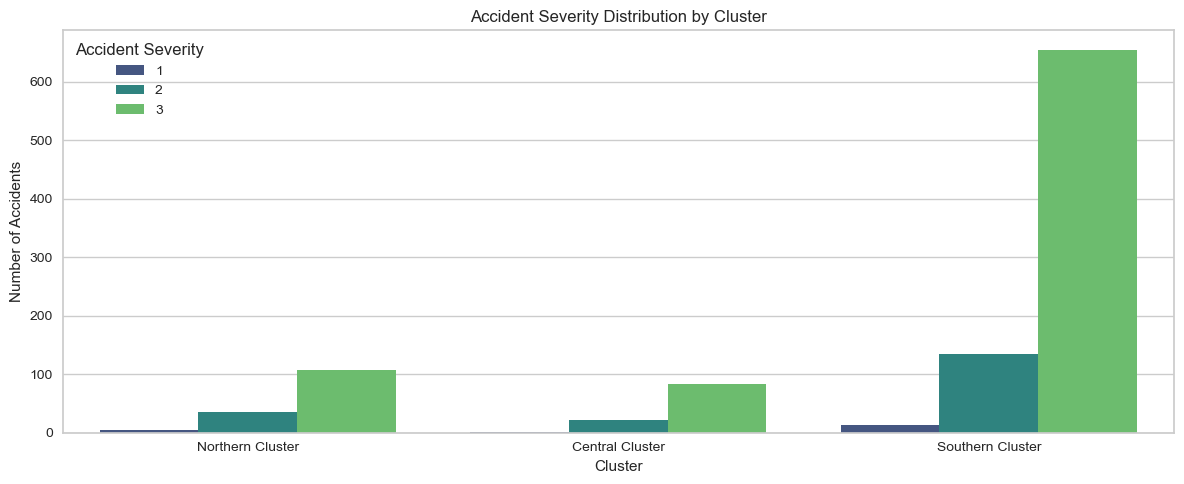

In [139]:

# Use KMeans to cluster the data into 3 clusters
coords = data_hull[['latitude', 'longitude']]
kmeans = KMeans(n_clusters=3, random_state=0).fit(coords)
data_hull['cluster'] = kmeans.labels_

# Accident Severity Distribution for each cluster
plt.figure(figsize=(12, 5))
sns.countplot(data=data_hull, x='cluster', hue='accident_severity', palette="viridis")
plt.title('Accident Severity Distribution by Cluster')
plt.ylabel('Number of Accidents')
plt.xlabel('Cluster')
plt.legend(title="Accident Severity")
plt.xticks(ticks=[0, 1, 2], labels=["Northern Cluster", "Central Cluster", "Southern Cluster"])
plt.tight_layout()
plt.show()


C:\Users\HP\anaconda3\lib\site-packages\seaborn\categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
C:\Users\HP\anaconda3\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
C:\Users\HP\anaconda3\lib\site-packages\seaborn\categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
C:\Users\HP\anaconda3\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
C:\Users\HP\anaconda3\lib\site-packages\seaborn\categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__ver

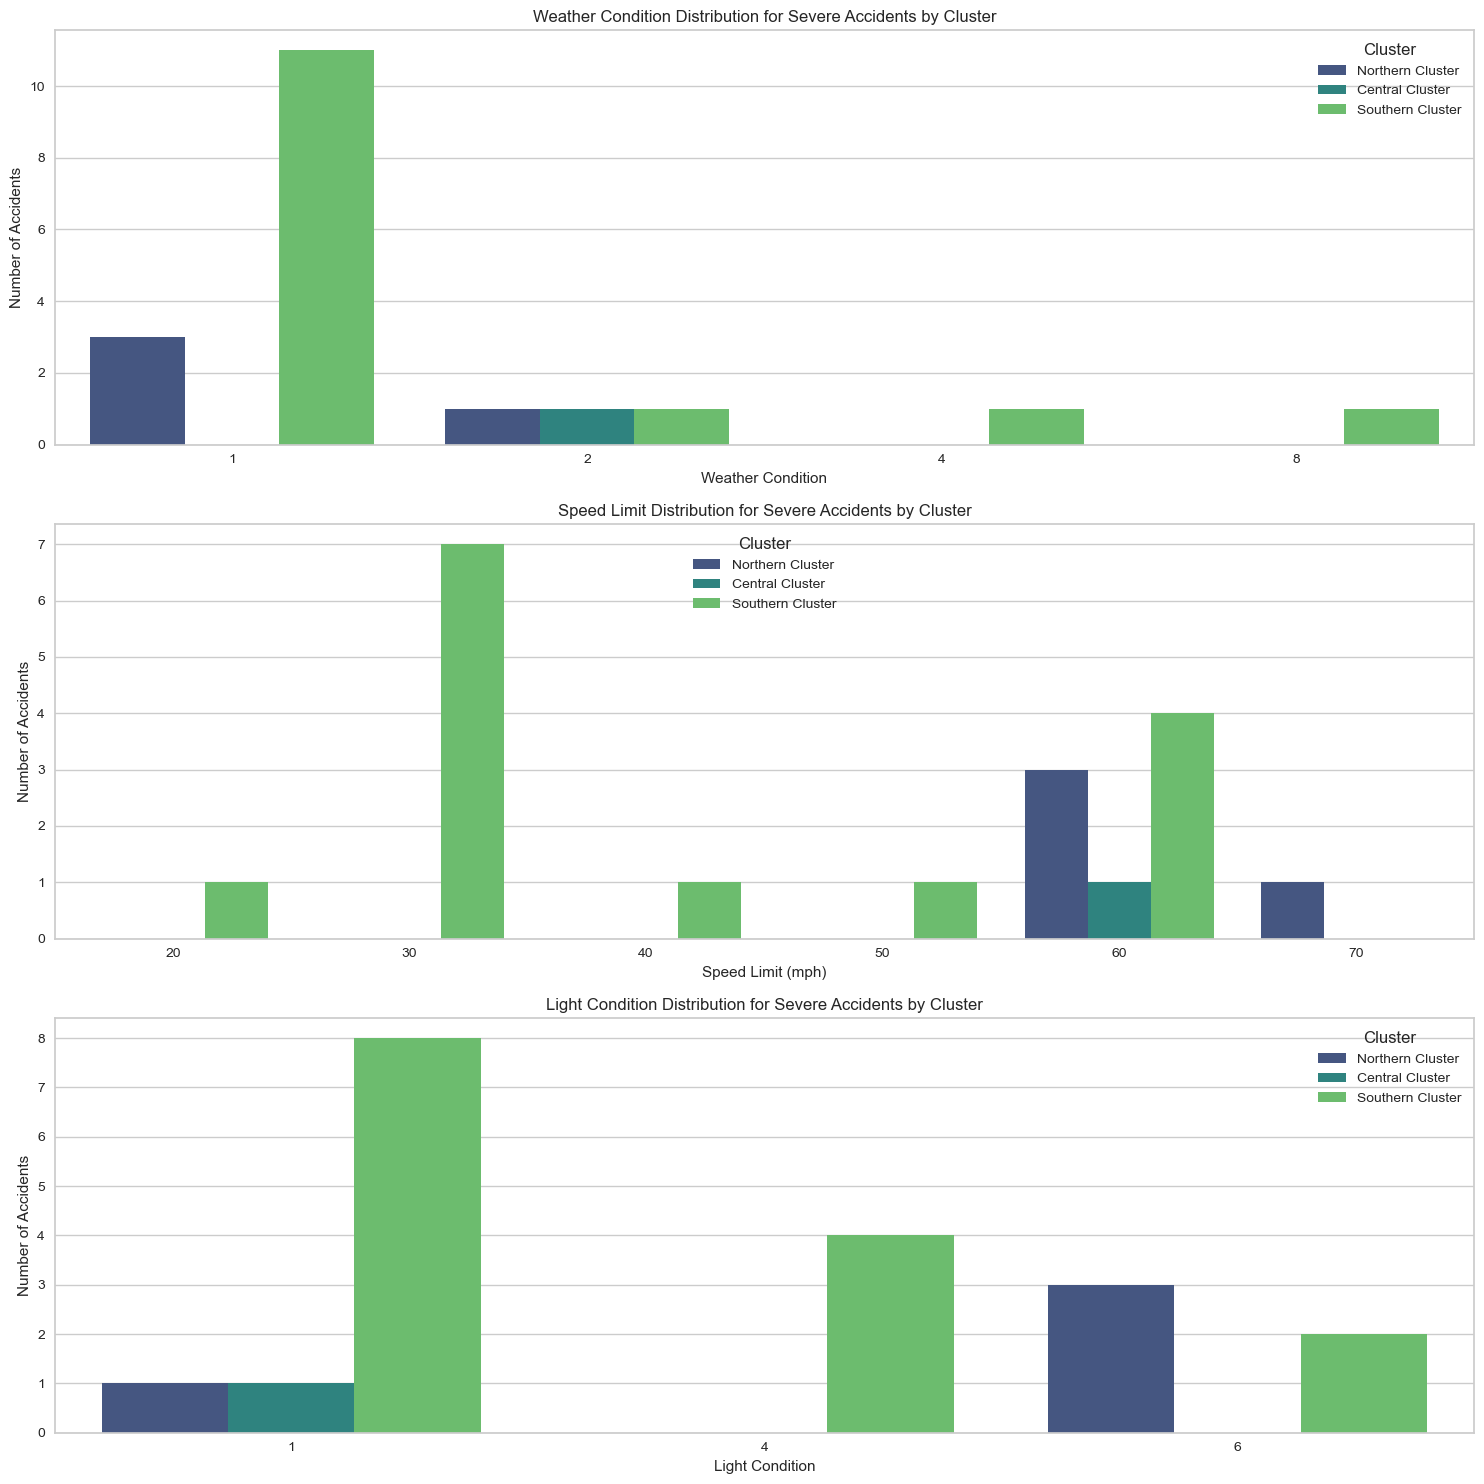

In [144]:
coords = data_hull[['latitude', 'longitude']]
kmeans = KMeans(n_clusters=3, random_state=0).fit(coords)
data_hull['cluster'] = kmeans.labels_

# Filter for severe accidents and plot the distributions
severe_accidents = data_hull[data_hull['accident_severity'] == 1]

fig, axs = plt.subplots(3, 1, figsize=(15, 15))

# Weather Condition Distribution
sns.countplot(data=severe_accidents, x='weather_conditions', hue='cluster', palette="viridis", ax=axs[0])
axs[0].set_title('Weather Condition Distribution for Severe Accidents by Cluster')
axs[0].set_ylabel('Number of Accidents')
axs[0].set_xlabel('Weather Condition')
axs[0].legend(title="Cluster", labels=["Northern Cluster", "Central Cluster", "Southern Cluster"])

# Speed Limit Distribution
sns.countplot(data=severe_accidents, x='speed_limit', hue='cluster', palette="viridis", ax=axs[1])
axs[1].set_title('Speed Limit Distribution for Severe Accidents by Cluster')
axs[1].set_ylabel('Number of Accidents')
axs[1].set_xlabel('Speed Limit (mph)')
axs[1].legend(title="Cluster", labels=["Northern Cluster", "Central Cluster", "Southern Cluster"])

# Light Condition Distribution
sns.countplot(data=severe_accidents, x='light_conditions', hue='cluster', palette="viridis", ax=axs[2])
axs[2].set_title('Light Condition Distribution for Severe Accidents by Cluster')
axs[2].set_ylabel('Number of Accidents')
axs[2].set_xlabel('Light Condition')
axs[2].legend(title="Cluster", labels=["Northern Cluster", "Central Cluster", "Southern Cluster"])

plt.tight_layout()
plt.show()


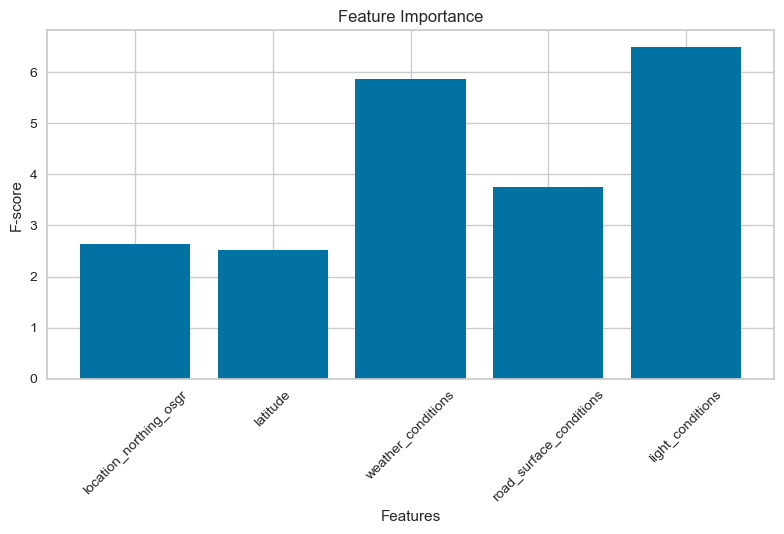

In [143]:
# Load the data
data = data_hull  

# Select relevant features for clustering and analysis
features = ['location_easting_osgr', 'location_northing_osgr', 'longitude', 'latitude',
            'speed_limit', 'junction_detail', 'road_type', 'weather_conditions', 'road_surface_conditions','light_conditions']

# The number of clusters
num_clusters = 4

# Initialize KMeans model
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

# Fit the model to the data
kmeans.fit(data[features])

# Add cluster labels to the original data
data['cluster_label'] = kmeans.labels_

# Get the most accident-occurring cluster
most_occuring_cluster = data['cluster_label'].value_counts().idxmax()

# Filter data for the most accident-occurring cluster
most_occuring_cluster_data = data[data['cluster_label'] == most_occuring_cluster]

# Select features and target variable
X = most_occuring_cluster_data[features]
y = most_occuring_cluster_data['accident_severity']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform feature selection using ANOVA F-test
num_features_to_select = 5
selector = SelectKBest(score_func=f_classif, k=num_features_to_select)
X_selected = selector.fit_transform(X_scaled, y)

# Get selected feature indices
selected_feature_indices = selector.get_support(indices=True)

# Get selected feature names
selected_feature_names = [features[idx] for idx in selected_feature_indices]

# Visualize the selected features' importance
plt.bar(selected_feature_names, selector.scores_[selected_feature_indices])
plt.xlabel('Features')
plt.ylabel('F-score')
plt.title('Feature Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [102]:
!pip install yellowbrick

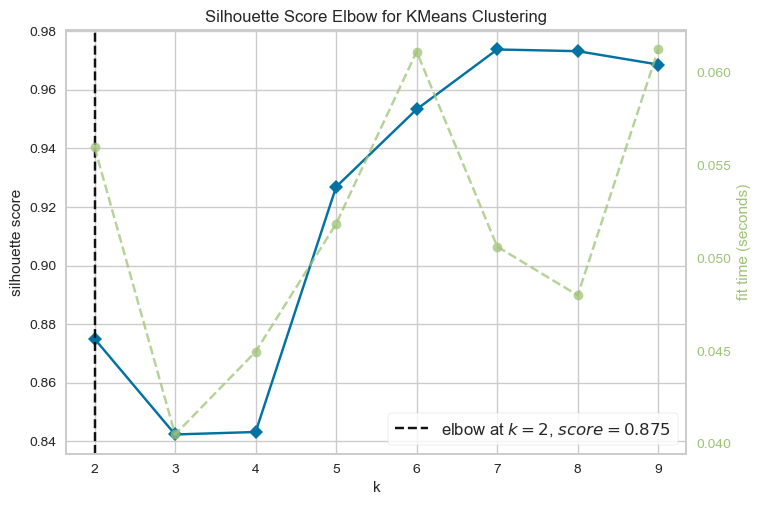

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [103]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Load the data for the region Kingston upon Hull
data_hull = pd.read_csv('combined_region_data.csv')

# Extract relevant data for clustering
data_for_clustering = data_hull[['accident_severity', 'weather_conditions']]

# Convert data to numpy array
X = data_for_clustering.to_numpy()

# Instantiate KMeans clustering model
model = KMeans()

# Instantiate the KElbowVisualizer with the metric you prefer (e.g., silhouette, calinski_harabasz, or inertia)
visualizer = KElbowVisualizer(model, k=(2, 10), metric='silhouette')

# Fit and visualize the elbow plot
visualizer.fit(X)
visualizer.show()


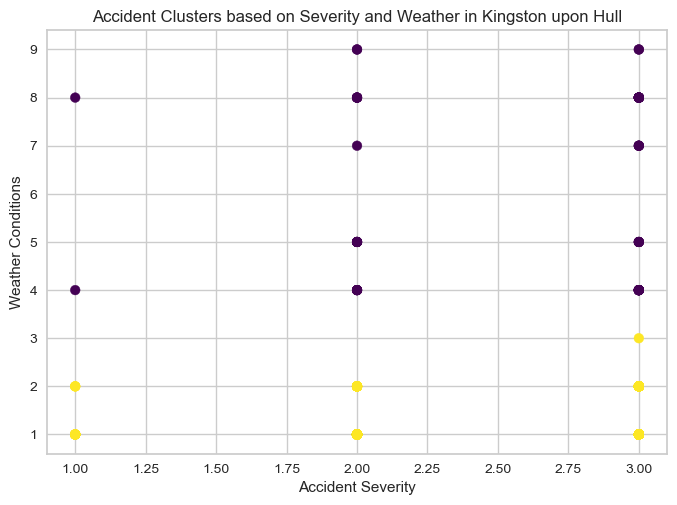

In [104]:
# Load the data for the region Kingston upon Hull
data_hull = pd.read_csv('combined_region_data.csv')  # Replace with the actual path to your CSV file

# Select relevant features for clustering
features = ['accident_severity', 'weather_conditions']

# Extract features for clustering
X = data_hull[features]

# Determine the number of clusters
num_clusters = 2  # You can adjust the number of clusters as needed

# Initialize KMeans model
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

# Fit the model to the data
kmeans.fit(X)

# Add cluster labels to the original data
data_hull['cluster_label'] = kmeans.labels_

# Visualize the clusters
plt.scatter(data_hull['accident_severity'], data_hull['weather_conditions'], c=data_hull['cluster_label'], cmap='viridis')
plt.xlabel('Accident Severity')
plt.ylabel('Weather Conditions')
plt.title('Accident Clusters based on Severity and Weather in Kingston upon Hull')
plt.show()


In [105]:
data_hull

,accident_index,accident_year,accident_reference,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,...,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,trunk_road_flag,lsoa_of_accident_location,cluster_label
0,2020160914930,2020,160914930,506050.0,428813.0,-0.393424,53.744936,16,3,2,...,1,1,1,0,0,1,1,2,E01012777,1
1,2020160915028,2020,160915028,510449.0,434112.0,-0.324858,53.791630,16,2,1,...,4,1,1,0,0,1,1,2,E01012788,1
2,2020160915047,2020,160915047,510322.0,431457.0,-0.327733,53.767805,16,3,1,...,4,1,1,0,3,1,1,2,E01012817,1
3,2020160915332,2020,160915332,511596.0,429551.0,-0.309102,53.750410,16,3,1,...,1,1,1,0,0,1,1,2,E01012810,1
4,2020160915337,2020,160915337,509786.0,432528.0,-0.335481,53.777540,16,3,2,...,4,1,1,0,0,1,1,2,E01012817,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1052,2020161012614,2020,161012614,504795.0,439763.0,-0.408728,53.843568,16,3,5,...,4,1,2,0,0,1,2,2,E01013037,1
1053,2020161012744,2020,161012744,503718.0,428641.0,-0.428826,53.743858,16,3,2,...,1,1,1,0,0,1,2,2,E01013107,1
1054,2020161012771,2020,161012771,471686.0,423873.0,-0.915506,53.706392,16,2,2,...,4,1,1,0,0,2,2,2,E01013074,1
1055,2020161013646,2020,161013646,502981.0,432285.0,-0.438783,53.776745,16,3,2,...,4,1,1,0,0,1,2,2,E01012954,1


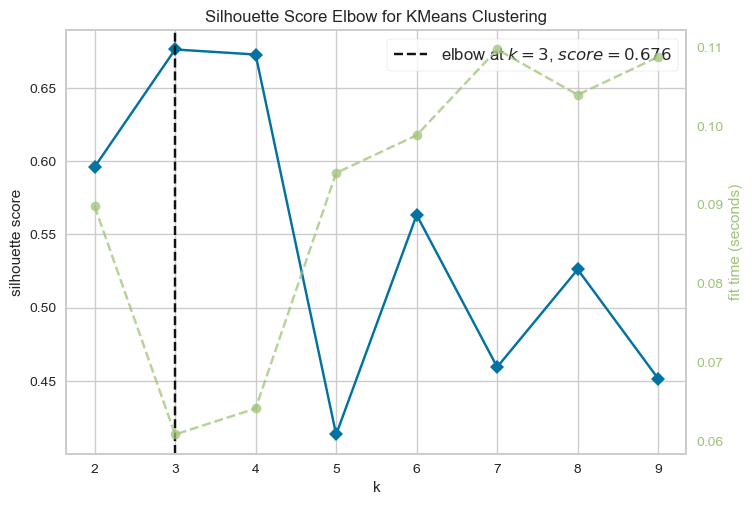

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [107]:
# Load your data into X

# Extract relevant data for clustering
data_for_clustering = data_hull[['location_easting_osgr', 'location_northing_osgr', 'longitude', 'latitude']]

# Convert data to numpy array
X = data_for_clustering.to_numpy()

# Instantiate KMeans clustering model
model = KMeans()

# Instantiate the KElbowVisualizer with the metric you prefer (e.g., silhouette, calinski_harabasz, or inertia)
visualizer = KElbowVisualizer(model, k=(2, 10), metric='silhouette')

# Fit and visualize the elbow plot
visualizer.fit(X)
visualizer.show()


## Outlier Analysis

Dixon’s Q Test
• This is a “gap” test.
• Cannot be used more than once!
• Key drawback problem: outliers might be grouped.
• The Q test will fail
How to use:
• Ensure data is in ascending order
• Calculate the gap from the suspicious point to the nearest other data point
• Calculate the range of the whole data set


The Multiple of IQR test.
• A very simple approach to identify outliers is to use the inter-quartile
range (the IQR).
• IQR is robust against outliers, in general.
• Outliers are then Upper Quartile + 1.5 IQR
or Lower Quartile – 1.5 IQR
• Might expect 1% of the data to be classified in this way.
• “Far Outliers” would use a multiple of 3 (rather than 1.5)

Grubbs test
this is the best method to find the outliers in the dataset, the major drawback is that it can be used to find one outlier at a time and
multiple iterataions will be required.

## Classification Model

In [109]:
accidents_2020_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91199 entries, 0 to 91198
Data columns (total 37 columns):
 #   Column                                       Non-Null Count  Dtype         
---  ------                                       --------------  -----         
 0   accident_index                               91199 non-null  object        
 1   accident_year                                91199 non-null  int64         
 2   accident_reference                           91199 non-null  object        
 3   location_easting_osgr                        91185 non-null  float64       
 4   location_northing_osgr                       91185 non-null  float64       
 5   longitude                                    91185 non-null  float64       
 6   latitude                                     91185 non-null  float64       
 7   police_force                                 91199 non-null  int64         
 8   accident_severity                            91199 non-null  int64         


In [110]:
import pandas as pd

# Merge accidents_2020_df and casualties_2020_df on 'accident_index'
accident_2020_merged = pd.merge(accidents_2020_df, casualties_2020_df, on='accident_index', how='inner')

# Merge the merged_data with vehicles_2020_df on 'accident_index'
accident_2020_merged = pd.merge(accident_2020_merged, vehicles_2020_df, on='accident_index', how='inner')

# Print the merged dataframe
print(merged_data)


       accident_index  accident_year_x accident_reference_x  \
0       2020010219808             2020            010219808   
1       2020010220496             2020            010220496   
2       2020010220496             2020            010220496   
3       2020010228005             2020            010228005   
4       2020010228006             2020            010228006   
...               ...              ...                  ...   
220430  2020991030297             2020            991030297   
220431  2020991030297             2020            991030297   
220432  2020991030900             2020            991030900   
220433  2020991030900             2020            991030900   
220434  2020991032575             2020            991032575   

        location_easting_osgr  location_northing_osgr  longitude   latitude  \
0                    521389.0                175144.0  -0.254001  51.462262   
1                    529337.0                176237.0  -0.139253  51.470327   
2     

In [111]:
accident_2020_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 220435 entries, 0 to 220434
Data columns (total 82 columns):
 #   Column                                       Non-Null Count   Dtype         
---  ------                                       --------------   -----         
 0   accident_index                               220435 non-null  object        
 1   accident_year_x                              220435 non-null  int64         
 2   accident_reference_x                         220435 non-null  object        
 3   location_easting_osgr                        220401 non-null  float64       
 4   location_northing_osgr                       220401 non-null  float64       
 5   longitude                                    220401 non-null  float64       
 6   latitude                                     220401 non-null  float64       
 7   police_force                                 220435 non-null  int64         
 8   accident_severity                            220435 non-null  in

In [112]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

data = accident_2020_merged

# Drop unnecessary columns
columns_to_drop = ['accident_reference_x', 'accident_reference_y', 'vehicle_reference_x', 'vehicle_reference_y', 'accident_year_y']
data = data.drop(columns=columns_to_drop)

# Separate target variable from features
X = data.drop(columns=['casualty_severity'])
y = data['casualty_severity']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocess categorical variables with one-hot encoding
categorical_columns = ['local_authority_ons_district', 'local_authority_highway', 'generic_make_model']
numeric_columns = X_train.select_dtypes(include=['number']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_columns),
        ('cat', OneHotEncoder(drop='first'), categorical_columns)
    ])

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)


In [113]:
data = accident_2020_merged

# Drop unnecessary columns
columns_to_drop = ['accident_reference_x', 'accident_reference_y', 'vehicle_reference_x', 'vehicle_reference_y', 'accident_year_y']
data = data.drop(columns=columns_to_drop)

# Separate target variable from features
X = data.drop(columns=['casualty_severity'])
y = data['casualty_severity']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Handle missing values (if present)
X_train = X_train.fillna(0)  # Replace NaN with 0, adjust this based on your data
X_test = X_test.fillna(0)

# Preprocess categorical variables with one-hot encoding
categorical_columns = ['local_authority_ons_district', 'local_authority_highway', 'generic_make_model']
numeric_columns = X_train.select_dtypes(include=['number']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_columns),
        ('cat', OneHotEncoder(drop='first'), categorical_columns)
    ])

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Initialize the Decision Tree Classifier
model = DecisionTreeClassifier(random_state=42)

# Fit the model on the preprocessed training data
model.fit(X_train_preprocessed, y_train)

# Predictions on the test data
y_pred = model.predict(X_test_preprocessed)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")


Accuracy: 0.9782


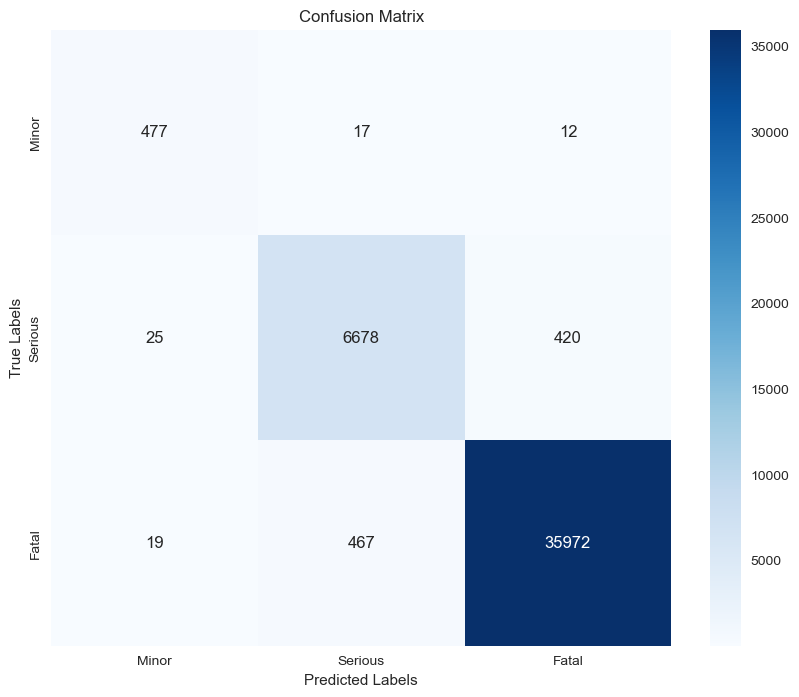

In [114]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions from your model
y_pred = model.predict(X_test_preprocessed)

# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Minor", "Serious", "Fatal"], yticklabels=["Minor", "Serious", "Fatal"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [115]:
# Calculate metrics
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
# roc_auc = roc_auc_score(y_test, y_pred, average='weighted', multi_class='ovo')

# Print metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)


Precision: 0.9782988536887959
Recall: 0.9782248735454896
F1-Score: 0.9782580143176058


In [ ]:
# Calculate metrics
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)


In [118]:
from sklearn.metrics import confusion_matrix, classification_report

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Print classification report
class_report = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(class_report)

# Calculate metrics
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
# roc_auc = roc_auc_score(y_test, y_pred, average='weighted', multi_class='ovo')

# Print metrics
print("\nMetrics:")
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)


Confusion Matrix:
[[  477    17    12]
 [   25  6678   420]
 [   19   467 35972]]

Classification Report:
              precision    recall  f1-score   support

           1       0.92      0.94      0.93       506
           2       0.93      0.94      0.93      7123
           3       0.99      0.99      0.99     36458

    accuracy                           0.98     44087
   macro avg       0.95      0.96      0.95     44087
weighted avg       0.98      0.98      0.98     44087


Metrics:
Precision: 0.9782988536887959
Recall: 0.9782248735454896
F1-Score: 0.9782580143176058


## Finding the best parameters

In [120]:
data = accident_2020_merged

# Drop unnecessary columns
columns_to_drop = ['accident_reference_x', 'accident_reference_y', 'vehicle_reference_x', 'vehicle_reference_y', 'accident_year_y']
data = data.drop(columns=columns_to_drop)

In [122]:
accident_2020_merged['casualty_severity'].info()

<class 'pandas.core.series.Series'>
Int64Index: 220435 entries, 0 to 220434
Series name: casualty_severity
Non-Null Count   Dtype
--------------   -----
220435 non-null  int64
dtypes: int64(1)
memory usage: 3.4 MB


In [124]:

# Define features and target
X = accident_2020_merged.drop(columns=['casualty_severity', 'accident_severity', 'did_police_officer_attend_scene_of_accident', 
                                       'accident_index', 'casualty_index', 'vehicle_reference','accident_reference_x', 
                                       'accident_reference_y', 'vehicle_reference_x', 'vehicle_reference_y', 'accident_year_y'], 
                               errors='ignore')
y = accident_2020_merged['casualty_severity']
y = (y == 1)

# Keep only numeric columns
X = X.select_dtypes([np.number])

# Handling missing values by replacing them with the median of the column
X = X.fillna(X.median())

# Replacing infinite values with NaN and then handling them as missing values
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median())

# Balancing the dataset using RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

# # Feature selection using SelectKBest
# selector = SelectKBest(f_classif, k=10)
# X_resampled_selected = selector.fit_transform(X_resampled, y_resampled)
# selected_features = X.columns[selector.get_support()]

# print(selected_features)


In [126]:

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# 1. DecisionTree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)
dt_preds = dt_classifier.predict(X_test)

# 2. KNeighbors Classifier
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(X_train, y_train)
knn_preds = knn_classifier.predict(X_test)

# 3. GaussianNB Classifier
gnb_classifier = GaussianNB()
gnb_classifier.fit(X_train, y_train)
gnb_preds = gnb_classifier.predict(X_test)

from sklearn.ensemble import RandomForestClassifier

# 4. RandomForest Classifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)
rf_preds = rf_classifier.predict(X_test)


# Displaying the performance of each classifier
print("DecisionTree Classifier Performance:")
print(classification_report(y_test, dt_preds))
print("Accuracy:", accuracy_score(y_test, dt_preds))
print("-------------------------------------------------")

print("KNeighbors Classifier Performance:")
print(classification_report(y_test, knn_preds))
print("Accuracy:", accuracy_score(y_test, knn_preds))
print("-------------------------------------------------")

print("RandomForest Classifier Performance:")
print(classification_report(y_test, rf_preds))
print("Accuracy:", accuracy_score(y_test, rf_preds))
print("-------------------------------------------------")


print("GaussianNB Classifier Performance:")
print(classification_report(y_test, gnb_preds))
print("Accuracy:", accuracy_score(y_test, gnb_preds))


C:\Users\HP\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


DecisionTree Classifier Performance:
              precision    recall  f1-score   support

       False       0.75      0.73      0.74       518
        True       0.73      0.75      0.74       510

    accuracy                           0.74      1028
   macro avg       0.74      0.74      0.74      1028
weighted avg       0.74      0.74      0.74      1028

Accuracy: 0.7402723735408561
-------------------------------------------------
KNeighbors Classifier Performance:
              precision    recall  f1-score   support

       False       0.67      0.63      0.65       518
        True       0.65      0.69      0.67       510

    accuracy                           0.66      1028
   macro avg       0.66      0.66      0.66      1028
weighted avg       0.66      0.66      0.66      1028

Accuracy: 0.6605058365758755
-------------------------------------------------
RandomForest Classifier Performance:
              precision    recall  f1-score   support

       False       0.87 

In [127]:
# Define a function to create the stacking ensemble
def get_stacking():
    # Define the base models (level0)
    level0 = list()
    level0.append(('dt', DecisionTreeClassifier(random_state=42)))
    level0.append(('knn', KNeighborsClassifier()))
    level0.append(('gnb', GaussianNB()))
    level0.append(('rf', RandomForestClassifier()))
    # Define meta learner model
    level1 = LogisticRegression()
    
    # Define the stacking
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    
    return model

# Get the stacking model
stacked_model = get_stacking()

# Fit the model
stacked_model.fit(X_train, y_train)

# Make predictions
stacked_preds = stacked_model.predict(X_test)

# Display the performance of the stacked model
print("Stacked Classifier Performance:")
print(classification_report(y_test, stacked_preds))
print("Accuracy:", accuracy_score(y_test, stacked_preds))


Stacked Classifier Performance:
              precision    recall  f1-score   support

       False       0.75      0.75      0.75       518
        True       0.75      0.75      0.75       510

    accuracy                           0.75      1028
   macro avg       0.75      0.75      0.75      1028
weighted avg       0.75      0.75      0.75      1028

Accuracy: 0.75


In [128]:
## hyper parameter tuning

In [129]:
# Hyperparameters grid
param_grid = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Grid search
grid_search = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
best_dt_classifier = grid_search.best_estimator_

# Performance
dt_preds = best_dt_classifier.predict(X_test)
print("Tuned DecisionTree Classifier Performance:")
print(classification_report(y_test, dt_preds))


Fitting 5 folds for each of 54 candidates, totalling 270 fits
Tuned DecisionTree Classifier Performance:
              precision    recall  f1-score   support

       False       0.75      0.73      0.74       518
        True       0.73      0.75      0.74       510

    accuracy                           0.74      1028
   macro avg       0.74      0.74      0.74      1028
weighted avg       0.74      0.74      0.74      1028



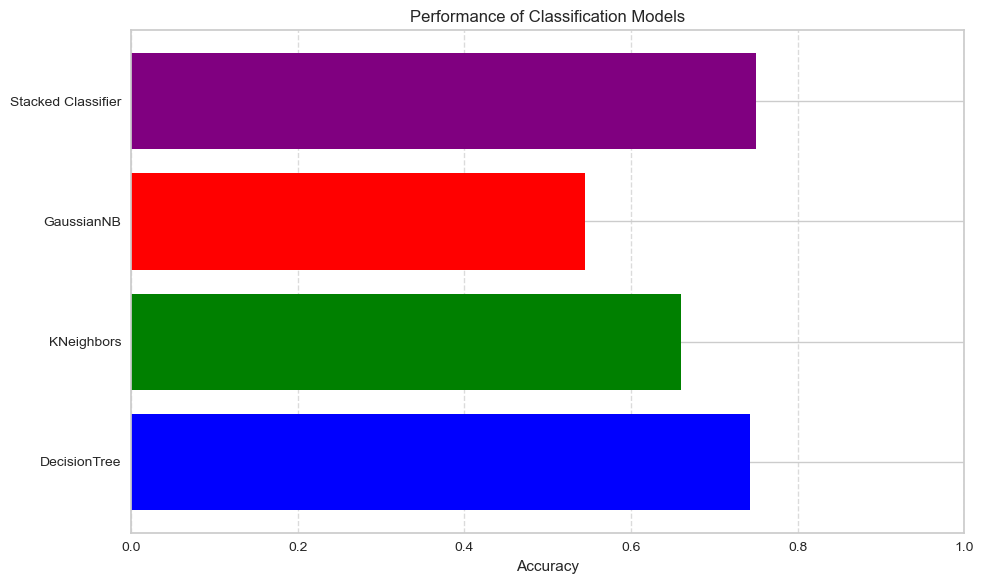

In [130]:
import matplotlib.pyplot as plt

# Evaluate the performance of the stacked classifier
stacked_preds = stacked_model.predict(X_test)
stacked_accuracy = accuracy_score(y_test, stacked_preds)

# Accuracy for each model
accuracies = {
    "DecisionTree": accuracy_score(y_test, dt_preds),
    "KNeighbors": accuracy_score(y_test, knn_preds),
    "GaussianNB": accuracy_score(y_test, gnb_preds),
    "RandomForestClassifier":accuracy_score(y_test, rf_preds), 
    "Stacked Classifier": stacked_accuracy
}

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(list(accuracies.keys()), accuracies.values(), color=['blue', 'green', 'red', 'purple'])
plt.xlabel("Accuracy")
plt.title("Performance of Classification Models")
plt.xlim(0, 1)  # assuming accuracy is between 0 and 1
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()